In [40]:
from scipy.sparse import data
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse as sp
import scipy.io as sio
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import argparse
from model import Dominant
from torch_geometric.nn import SAGEConv, GATConv
from torch_geometric.utils import sort_edge_index
from time import process_time_ns 
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import pandas as pd
from torch_geometric.datasets import DGraphFin
import json

In [41]:
def getAverageDegree(data):
    data_mat = sio.loadmat(data)
    adj = data_mat['Network']
    truth = data_mat['Label']
    attributes = data_mat['Attributes']
    print("type: ",type(attributes[0][0][0]), attributes.shape)
    non_zero_counts = attributes.getnnz(axis=1)  # Number of non-zeros per row (node)
    average_attributes = np.mean(non_zero_counts)
    print("average_attributes: ", average_attributes)
    _, [normal, anomalous] = np.unique(truth, return_counts=True)
    total_nodes = normal + anomalous
    print("total nodes: ", total_nodes)
    print("normal nodes: ", normal)
    print("anomalous nodes: ", anomalous)
    print("% of anomalous nodes: ", (anomalous/total_nodes)*100)
    print(type(adj))
    
    if (abs(adj-adj.T)>1e-10).nnz == 0:
        print("is not symmetric")
    else:
        print("is symmetric")
    # Calculate the total degree by summing the degrees for each node
    # For an undirected graph represented in CSC, each non-zero entry in the data array represents an edge
    total_degree = adj.data.size

    # Calculate the average degree of the nodes
    # In an undirected graph, each edge is counted twice (once for each node it connects), so divide by 2
    average_degree = total_degree / total_nodes
    vertices = adj.shape[0]
    edges = adj.nnz // 2
    print("vertices: ", vertices)
    print("edges: ", edges)
    print("density: ", (2*edges) / (vertices*(vertices-1)))
    return average_degree

In [42]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [43]:
datum = [f'data/ACM.mat', f'data/Flickr.mat', f'data/BlogCatalog.mat']
for data in datum:
    print(data, ": ")
    print("avg. degree: ", getAverageDegree(data), "\n\n")
    

data/ACM.mat : 
type:  <class 'scipy.sparse._csc.csc_matrix'> (16484, 8337)
average_attributes:  28.84603251637952
total nodes:  16484
normal nodes:  15887
anomalous nodes:  597
% of anomalous nodes:  3.6216937636496
<class 'scipy.sparse._csc.csc_matrix'>
is symmetric
vertices:  16484
edges:  82175
density:  0.000604882254764908
avg. degree:  9.970274205289979 


data/Flickr.mat : 
type:  <class 'scipy.sparse._csc.csc_matrix'> (7575, 12047)
average_attributes:  29.79102310231023
total nodes:  7575
normal nodes:  7130
anomalous nodes:  445
% of anomalous nodes:  5.874587458745874
<class 'scipy.sparse._csc.csc_matrix'>
is symmetric
vertices:  7575
edges:  241277
density:  0.008410813090815287
avg. degree:  63.703630363036304 


data/BlogCatalog.mat : 
type:  <class 'scipy.sparse._csc.csc_matrix'> (5196, 8189)
average_attributes:  79.2186297151655
total nodes:  5196
normal nodes:  4898
anomalous nodes:  298
% of anomalous nodes:  5.7351809083910705
<class 'scipy.sparse._csc.csc_matrix'>
i

In [44]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    #co ordinate matrix 
    adj = sp.coo_matrix(adj)
    print('ty: ', type(adj))
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def load_anomaly_detection_dataset(dataset, datadir='data'):
    if dataset == "finGraph":
        global fin_adj_norm
        global fin_feat
        global fin_truth
        global fin_adj
        global fin_edge_types
        return fin_adj_norm, fin_feat, fin_truth, fin_adj, fin_edge_types
    data_mat = sio.loadmat(f'{datadir}/{dataset}.mat')
    adj = data_mat['Network']
    feat = data_mat['Attributes']
    truth = data_mat['Label']
    truth = truth.flatten()
    print("TYPE: ", type(adj + sp.eye(adj.shape[0])))
    adj_norm = normalize_adj(adj + sp.eye(adj.shape[0]))
    adj_norm = adj_norm.toarray()
    adj = adj + sp.eye(adj.shape[0])
    adj = adj.toarray()
    feat = feat.toarray()
    
    
    return adj_norm, feat, truth, adj

In [45]:
_ = load_anomaly_detection_dataset("BlogCatalog")

TYPE:  <class 'scipy.sparse._csc.csc_matrix'>
ty:  <class 'scipy.sparse._coo.coo_matrix'>


In [46]:
def downsample_to_k(data, k = 1000, target_true_values = 8000, total_values = 3700550):
    label = (data.y == 1)
    train_filter = data.train_mask

    # Step 1: Logical AND to find True in both tensors and select k of these indices
    combined_true_indices = (train_filter & label).nonzero(as_tuple=False).view(-1)
    if combined_true_indices.numel() < k:
        raise ValueError("Not enough True values after AND operation to select k True values.")
    selected_combined_indices = combined_true_indices[torch.randperm(combined_true_indices.numel())[:k]]

    # Prepare a mask for exclusion
    exclude_mask = torch.zeros_like(train_filter, dtype=torch.bool)
    exclude_mask[selected_combined_indices] = True

    # Step 2: Select target_true_values True indices from filter, making sure not to select already chosen indices
    filter_true_indices = train_filter.nonzero(as_tuple=False).view(-1)
    # Apply the exclusion mask
    eligible_filter_indices = filter_true_indices[~exclude_mask[filter_true_indices]]

    if eligible_filter_indices.numel() < target_true_values:
        raise ValueError("Not enough True values in filter to select {} unique True values.".format(target_true_values))
    selected_filter_indices = eligible_filter_indices[torch.randperm(len(eligible_filter_indices))[:target_true_values]]

    # Combine the two sets of indices
    final_selected_indices = torch.cat((selected_combined_indices, selected_filter_indices))
    print("no. of final_selected_indices: ", len(final_selected_indices))
    # Step 3: Create a new tensor filled with False and set selected indices to True
    new_tensor = torch.zeros_like(train_filter)
    new_tensor[final_selected_indices] = True
    data.train_mask = new_tensor

    return data

def get_filtered_edges(data):
    # Assuming edge_index is a numpy array of shape [2, num_edges] and train_mask is a 1D boolean array
    filtered_edges = []
    filtered_edge_type = []

    for idx, edge in enumerate(data.edge_index.T):  # Transpose to iterate over edges
        if data.train_mask[edge[0]] and data.train_mask[edge[1]]:
            filtered_edges.append(edge)
            filtered_edge_type.append(data.edge_type[idx] - 1) # subtract 1 as it is 1 indexed
    print("len(filtered_edges): ", len(filtered_edges))
    print("len(filtered_edge_type): ", len(filtered_edge_type))
    filtered_edges = np.array(filtered_edges).T  # Convert back to original shape
    return filtered_edges, filtered_edge_type

def get_adj_matrix(filtered_edge_type, filtered_edges, node_count):
    # Map nodes to new indices
    unique_nodes = np.unique(filtered_edges)
    node_to_new_idx = {node: idx for idx, node in enumerate(unique_nodes)}

    # Remap edges to new indices
    remapped_edges = np.vectorize(node_to_new_idx.get)(filtered_edges)
    remapped_edge_type = np.vectorize(node_to_new_idx.get)(filtered_edge_type)

    # Create the COO format sparse matrix and then convert to CSC format
    num_nodes_subgraph = len(unique_nodes)
    print("num_nodes_subgraph: ", num_nodes_subgraph)
    row = remapped_edges[0]
    col = remapped_edges[1]
    # Find indices where row and col are different (no self-loop)
    non_self_loop_indices = row != col
    print("non_self_loop_indices: ", len(non_self_loop_indices))
    # Filter the arrays to remove self-loops
    row = row[non_self_loop_indices]
    col = col[non_self_loop_indices]

    data = np.ones(len(row))  # Assuming unweighted graph for simplicity
    adj_matrix_coo = coo_matrix((data, (row, col)), shape=(node_count, node_count))
    adj_matrix_csc = adj_matrix_coo.tocsc()
    return adj_matrix_csc, remapped_edge_type

# data
def get_fin_graph_data():
    dataset = DGraphFin(root='data')
    data = dataset[0]
    data = match_graph_density(data, data)
#     data = downsample_to_k(data)
    
    filtered_edges, filtered_edge_type = get_filtered_edges(data)
    node_count = data.train_mask.sum()
    adj_matrix_csc, filtered_edges = get_adj_matrix(filtered_edge_type, filtered_edges, node_count)
    
    adj_norm = normalize_adj(adj_matrix_csc + sp.eye(adj_matrix_csc.shape[0]))
    adj_norm = adj_norm.toarray()
    
    
    adj = adj_matrix_csc.toarray()
    
    feat = data.x[data.train_mask].numpy()
    truth = data.y[data.train_mask].numpy()
    
    return adj_norm, feat, truth, adj, torch.LongTensor(filtered_edge_type), filtered_edges

In [47]:
def calculate_density(num_edges, num_nodes):
    if num_nodes <= 1:
        return 0  # Avoid division by zero
    return num_edges / (num_nodes * (num_nodes - 1))

def match_graph_density(data, data2, k=1000, target_true_values=8000, max_iterations=100, tolerance=0.01):
    # Calculate density of data2
    num_edges_data2 = data2.edge_index.size(1)  # Assuming edge_index for edges
    num_nodes_data2 = data2.x.size(0)  # Assuming x has node features
    target_density = calculate_density(num_edges_data2, num_nodes_data2)
    
    for iteration in range(max_iterations):
        # Apply downsample_to_k
        data = downsample_to_k(data, k, target_true_values)
        
        # Calculate the density of the resulting graph
        num_edges_data = data.edge_index.size(1)
        num_nodes_data = data.x.size(0)
        current_density = calculate_density(num_edges_data, num_nodes_data)
        
        print(f"Iteration {iteration + 1}: Current density = {current_density}, Target density = {target_density}")
        
        # Check if the current density is within the tolerance
        if abs(current_density - target_density) <= tolerance:
            print("Desired density achieved.")
            return data
    
    raise RuntimeError("Max iterations reached without achieving the desired density.")


### 44 egdes 72 nodes

In [48]:
fin_adj_norm, fin_feat, fin_truth, fin_adj, fin_edge_types, filtered_edges = get_fin_graph_data()

no. of final_selected_indices:  9000
Iteration 1: Current density = 3.140775581876861e-07, Target density = 3.140775581876861e-07
Desired density achieved.
len(filtered_edges):  42
len(filtered_edge_type):  42
num_nodes_subgraph:  72
non_self_loop_indices:  42
ty:  <class 'scipy.sparse._coo.coo_matrix'>


In [19]:
fin_edge_types

tensor([0, 3, 4, 4, 7, 8, 4, 0, 0, 0, 4, 4, 2, 9, 1, 3, 4, 5, 4, 2, 1, 4, 4, 2,
        4, 4, 4, 0, 3, 0, 4, 3, 0, 4, 3, 3, 0, 5])

In [20]:
pd.unique(pd.Series(fin_edge_types))

array([0, 3, 4, 7, 8, 2, 9, 1, 5])

In [253]:
np.unique(fin_truth, return_counts=True)

(array([0, 1]), array([7924, 1076]))

In [254]:
fin_adj.sum()

45.0

In [102]:
import math

from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter

class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    # Initializes the GCN layer with input and output feature dimensions,
    # and an optional bias term.
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Define the weight matrix as a learnable parameter of shape (in_features, out_features)
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    
    # Initialize the weights and biases using a uniform distribution
    # with range determined by the inverse square root of the number of output features.

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        # linear transformation of the input features using the weight matrix.
        support = torch.mm(input, self.weight)
        
        # apply the adjacency matrix to the transformed features to propagate the features across the graph
        output = torch.spmm(adj, support) if adj.is_sparse else torch.mm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output


    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Encoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(Encoder, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        I = torch.eye(adj.size(0)).to(adj.device)
        if adj.is_sparse:
            I = I.to_sparse()
        adj_with_self_loops = adj + I
        
        x = F.relu(self.gc1(x, adj_with_self_loops))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj_with_self_loops))

        return x

class Attribute_Decoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(Attribute_Decoder, self).__init__()

        self.gc1 = GraphConvolution(nhid, nhid)
        self.gc2 = GraphConvolution(nhid, nfeat)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))

        return x

class Structure_Decoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(Structure_Decoder, self).__init__()

        self.gc1 = GraphConvolution(nhid, nhid)
        self.gc2 = GraphConvolution(nhid, nfeat)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = x @ x.T        #this is matrix multiplication

        return x

class Dominant(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout):
        super(Dominant, self).__init__()
        
        self.shared_encoder = Encoder(feat_size, hidden_size, dropout)
        self.attr_decoder = Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(feat_size, hidden_size, dropout)
    
    def forward(self, x, adj):
        # encode
        x = self.shared_encoder(x, adj)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

## RGCN Architecture

In [224]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class RGCN_Encoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(RGCN_Encoder, self).__init__()

        self.gc1 = RGCNConv(nfeat, nhid, num_relations=11)
        self.gc2 = RGCNConv(nhid, nhid, num_relations=11)
        self.dropout = dropout

    def forward(self, x, adj, edge_type):
        edge_index = adj.nonzero().t().contiguous()
#         print(len(edge_index), len(edge_type))
        non_self_loop_mask = edge_index[0] != edge_index[1]

        # Applying the mask to filter out self-loops
        filtered_edge_index = edge_index[:, non_self_loop_mask]
        x = F.relu(self.gc1(x, filtered_edge_index, edge_type))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, filtered_edge_index, edge_type))

        return x

class Attribute_Decoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(Attribute_Decoder, self).__init__()

        self.gc1 = GraphConvolution(nhid, nhid)
        self.gc2 = GraphConvolution(nhid, nfeat)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))

        return x

class Structure_Decoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(Structure_Decoder, self).__init__()

        self.gc1 = GraphConvolution(nhid, nhid)
        self.gc2 = GraphConvolution(nhid, nfeat)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = x @ x.T        #this is matrix multiplication

        return x

class Dominant_RGCN(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout):
        super(Dominant_RGCN, self).__init__()
        
        self.shared_encoder = RGCN_Encoder(feat_size, hidden_size, dropout)
        self.attr_decoder = Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(feat_size, hidden_size, dropout)
    
    def forward(self, x, adj, edge_type):
        # encode
        x = self.shared_encoder(x, adj, edge_type)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

## GAT Encoder using pgG GATConvLayer

In [13]:
class pyGATEncoder(Module):
    def __init__(self, in_features, out_features, dropout, heads = 1, 
                 concat = True, negative_slope = 0.2, 
                 add_self_loops = True,
                 fill_value = 'mean', bias = True):
        super(pyGATEncoder, self).__init__()
        self.gat1 = GATConv(in_features, out_features * 2, concat=concat)
        self.gat2 = GATConv(out_features * 2, out_features, concat=concat)
        self.gat3 = GATConv(out_features, out_features, concat=False)
        self.dropout = dropout

    def forward(self, x, adj):
        edge_index = adj.nonzero().t().contiguous()
        
        x = F.relu(self.gat1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gat2(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gat3(x, edge_index)
        return x

class pyGAT_Attribute_Decoder(nn.Module):
    def __init__(self, nfeat, nhid, dropout, concat = True):
        super(pyGAT_Attribute_Decoder, self).__init__()
        self.gat1 = GATConv(nhid, nhid, concat=concat)
        self.gat2 = GATConv(nhid, nfeat, concat=False)
        self.dropout = dropout
        
    def forward(self, x, adj):
        edge_index = adj.nonzero().t().contiguous()
        
        x = F.relu(self.gat1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x
    
class Dominant_pyGGAT(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout, heads = 1, 
                 concat = True, negative_slope = 0.2, add_self_loops = True,
                 fill_value = 'mean', bias = True):
        super(Dominant_pyGGAT, self).__init__()
        
        self.shared_encoder = pyGATEncoder(feat_size, hidden_size, dropout, heads = 1, 
                                        concat = True, negative_slope = 0.2, add_self_loops = True,
                                           fill_value = 'mean', bias = True)
        self.attr_decoder = pyGAT_Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(feat_size, hidden_size, dropout)
    
    def forward(self, x, adj):
        # encode
        x = self.shared_encoder(x, adj)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

## GraphSAGE Encoder using pgG SAGEConv Layer

In [14]:
class GraphSAGEEncoder(Module):
    def __init__(self, in_features, out_features, dropout, aggr='mean', project=True):
        super(GraphSAGEEncoder, self).__init__()
        # Define two GraphSAGE convolutional layers
        self.sage1 = SAGEConv(in_features, out_features * 2, aggr=aggr, project=project)
        self.sage2 = SAGEConv(out_features * 2, out_features, aggr=aggr, project=project)
        self.sage3 = SAGEConv(out_features, out_features, aggr=aggr, project=project)
        self.dropout = dropout

    def forward(self, x, adj):
        edge_index = adj.nonzero().t().contiguous()
#         edge_index = sort_edge_index(edge_index, sort_by_row=False)
        # Apply the first GraphSAGE layer and a ReLU activation
        x = F.relu(self.sage1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = F.relu(self.sage2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        

        x = self.sage3(x, edge_index)
        
        return x


class Dominant_GraphSAGE(nn.Module):
    def __init__(self, feat_size, hidden_size, dropout):
        super(Dominant_GraphSAGE, self).__init__()
        
        self.shared_encoder = GraphSAGEEncoder(feat_size, hidden_size, dropout)
        self.attr_decoder = Attribute_Decoder(feat_size, hidden_size, dropout)
        self.struct_decoder = Structure_Decoder(feat_size, hidden_size, dropout)
    
    def forward(self, x, adj):
        # encode
        x = self.shared_encoder(x, adj)
        # decode feature matrix
        x_hat = self.attr_decoder(x, adj)
        # decode adjacency matrix
        struct_reconstructed = self.struct_decoder(x, adj)
        # return reconstructed matrices
        return struct_reconstructed, x_hat

In [264]:
def loss_func(adj, A_hat, attrs, X_hat, alpha):
    # Attribute reconstruction loss
    diff_attribute = torch.pow(X_hat - attrs, 2)
    attribute_reconstruction_errors = torch.sqrt(torch.sum(diff_attribute, 1))
    attribute_cost = torch.mean(attribute_reconstruction_errors)

    # structure reconstruction loss
    diff_structure = torch.pow(A_hat - adj, 2)
    structure_reconstruction_errors = torch.sqrt(torch.sum(diff_structure, 1))
    structure_cost = torch.mean(structure_reconstruction_errors)

    cost =  alpha * attribute_reconstruction_errors + (1-alpha) * structure_reconstruction_errors

    return cost, structure_cost, attribute_cost

In [265]:
def train_dominant(encoder="OG", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, 
                   dropout=0.3, alpha=0.8, device="mps", heads = 1, 
                 concat = True, negative_slope = 0.2, add_self_loops = True,
                 fill_value = 'mean', bias = True):
    if dataset != "finGraph":
        adj, attrs, label, adj_label = load_anomaly_detection_dataset(dataset)
    else:
        adj, attrs, label, adj_label, fin_edge_types = load_anomaly_detection_dataset(dataset)
    print("dataset load complete")
    adj = torch.FloatTensor(adj)
    adj_label = torch.FloatTensor(adj_label)
    attrs = torch.FloatTensor(attrs)
    start_time = process_time_ns()
    if encoder == "OG":
        model = Dominant(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)
    elif encoder == "GAT":
        model = Dominant_GAT(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)
    elif encoder == "pyGGAT":
        model= Dominant_pyGGAT(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout, heads = heads, 
                 concat = concat, negative_slope = negative_slope, add_self_loops = add_self_loops,
                 fill_value = fill_value, bias = bias)
    elif encoder == "GraphSAGE":
        model = Dominant_GraphSAGE(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)
    elif encoder == "RGCN":
        model = Dominant_RGCN(feat_size = attrs.size(1), hidden_size = hidden_dim, dropout = dropout)

    else:
        print("Invalid Encoder specified\n")
        return
    print("encoder initialized")
    if device == 'cuda':
        device = torch.device(device)
        adj = adj.to(device)
        adj_label = adj_label.to(device)
        attrs = attrs.to(device)
        model = model.cuda() 
        
    
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)
    loss_dict = {
        "struct_loss": [],
        "feat_loss": [],
        "loss": []
    }
    precision = recall = thresholds = 1
    print("starting training")
    for epoch in range(max_epoch):
        model.train()
        optimizer.zero_grad()
        # returns the reconstructed matrices
        if encoder == "RGCN" and dataset == "finGraph":
            A_hat, X_hat = model(attrs, adj, fin_edge_types)
        else:
            A_hat, X_hat = model(attrs, adj)
        loss, struct_loss, feat_loss = loss_func(adj_label, A_hat, attrs, X_hat, alpha)
        l = torch.mean(loss)
        l.backward()
        optimizer.step()        
        loss_dict["struct_loss"].append(struct_loss.item())
        loss_dict["feat_loss"].append(feat_loss.item())
        loss_dict["loss"].append(l.item())
        if epoch%10 == 0 or epoch == max_epoch - 1:
            print("Epoch:", '%04d' % (epoch))
            model.eval()
            score = loss.detach().cpu().numpy()
#             print("Score: ", score)
            normalizedScore = (score - np.min(score))/(np.max(score)-np.min(score))
#             print("normalizedScore: ", normalizedScore)
#             precision, recall, thresholds = precision_recall_curve(label, normalizedScore) #modified 
    
    
    
#     auc = roc_auc_score(label, score)
    print("Epoch:", '%04d' % (epoch), 
          "train_loss=", "{:.5f}".format(l.item()), 
          "train/struct_loss=", "{:.5f}".format(struct_loss.item()),
          "train/feat_loss=", "{:.5f}".format(feat_loss.item()))
#           'Auc', auc)
    end_time = process_time_ns()
    
    response = {
        "loss_dict": loss_dict,
        "time_elapsed": end_time - start_time,
        "PR_curve": {
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds
        },
        "auc": auc,
        "score": score,
        "label": label
    }
    return response

In [17]:
def normalize_loss(loss_df):
    scaler = MinMaxScaler()
    x = loss_df["loss"].values.reshape(-1, 1)
    x_scaled = scaler.fit_transform(x)
    loss_df['normalized_loss'] = x_scaled
    return loss_df

def get_loss_df(loss, label):
    loss_df = pd.DataFrame([loss, label])
    loss_df = loss_df.T
    loss_df =loss_df.rename(columns={0: "loss", 1: "label"})
    loss_df = loss_df.sort_values('loss', ascending=False)
    loss_df = normalize_loss(loss_df)
    return loss_df

def get_recall(loss_df, k):
    total_anomalies = loss_df["label"].value_counts()[1]
    anomalies_at_k = loss_df["label"].iloc[:k].value_counts()[1]
    return round(anomalies_at_k/total_anomalies, 3)

def get_precision(loss_df, k):
    return round(precision_score(loss_df["label"].iloc[:k], [1]*k), 3)

def get_precision_recall(loss, label, k):
#     loss = loss.detach().cpu().numpy()
    loss_df = get_loss_df(loss, label)
    recall = get_recall(loss_df, k)
    precision = get_precision(loss_df, k)
    return precision, recall

def get_precision_recall_data(responses):
    precision_data = {}
    recall_data = {}
    for dataset in datasets:
        precision_data[dataset] = {}
        recall_data[dataset] = {}
        for encoder in encoders:
            for k in [50, 100, 200, 300]:
                label = responses[encoder][dataset][64]["label"]
                score = responses[encoder][dataset][64]["score"]
                precision, recall = get_precision_recall(score, label, k)
                precision_data[dataset][(encoder, k)] = precision
                recall_data[dataset][(encoder, k)] = recall

    return precision_data, recall_data

In [18]:
def get_results(data):
    reorganized_data = {}
    for dataset, values in data.items():
        for (method, K), precision in values.items():
            reorganized_data[(dataset, K)] = reorganized_data.get((dataset, K), {})
            reorganized_data[(dataset, K)][method] = precision

    # Convert reorganized data into a DataFrame
    df = pd.DataFrame(reorganized_data)

    # Adjust column levels
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=['Dataset', 'K'])

    # Optionally sort the columns if needed
    df.sort_index(axis=1, level='Dataset', inplace=True)

    return df

In [19]:
def run(encoders, datasets, hidden_dims, max_epochs, lrs, alpha=0.8):
    responses = {}
    for encoder in encoders:
        responses[encoder] = {}
        for dataset in datasets:
            responses[encoder][dataset] = {}
            for hidden_dim in [64]:
                print("encoder: {} --- dataset: {} --- hidden_dim: {}".format(encoder, dataset, hidden_dim))
                responses[encoder][dataset][hidden_dim] = {}
                curr_res = train_dominant(encoder=encoder, dataset=dataset, hidden_dim=hidden_dim, 
                                          max_epoch=100, lr=5e-2, dropout=0.3, alpha=alpha, device="mps")
                responses[encoder][dataset][hidden_dim] = curr_res
                print("time taken: {} min\n".format(curr_res["time_elapsed"]/60))
    return responses

In [20]:
def get_results_for_single_response(response, datasets=["BlogCatalog"], encoders=["OG"]):
    for k in [50, 100, 200, 300]:
        print("K: ", k)
        score = response["score"]
        label = response["label"]
        p, r = get_precision_recall(score, label, k)
        print("P: ", p, "   ---  R: ", r)

In [266]:
finGraph_RGCN_response = train_dominant(encoder="RGCN", dataset="finGraph", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

dataset load complete
encoder initialized
starting training
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= nan train/struct_loss= nan train/feat_loss= nan


In [232]:
finGraph_RGCN_precision, finGraph_RGCN_recall = get_precision_recall_data(finGraph_RGCN_response)

KeyError: 'GraphSAGE'

In [30]:
fingraph_precision, fingraph_recall = get_precision_recall_data(fingraph_response)

In [268]:
epoch_300_response_df = pd.read_json('epoch_300_response.json')

In [288]:
epoch_300_response_df["OG"]["ACM"]["64"].keys()

dict_keys(['loss_dict', 'time_elapsed', 'PR_curve', 'auc', 'score', 'label'])

In [272]:
fingraph_response_mar31 = pd.read_json('fingraph_response_mar31.json')

In [292]:
print(fingraph_response_mar31['OG']['finGraph']['64']['auc'])

0.5621793614219031


In [578]:
get_results(ep_300_precision)

Dataset     ACM                   BlogCatalog                    Flickr        \
K           50    100   200   300         50    100   200    300    50    100   
OG         0.16  0.16  0.17  0.18         0.7  0.61  0.49  0.397   0.34  0.41   
pyGGAT     0.16  0.16  0.17  0.18         0.7  0.61  0.49  0.393   0.18  0.37   
GraphSAGE  0.16  0.16  0.17  0.18         0.7  0.61  0.49  0.393   0.18  0.37   

Dataset                  
K            200    300  
OG         0.405  0.343  
pyGGAT     0.380  0.323  
GraphSAGE  0.380  0.323

In [580]:
get_results(ep_300_recall)

Dataset      ACM                     BlogCatalog                      Flickr  \
K            50     100    200   300         50     100    200    300    50    
OG         0.013  0.027  0.057  0.09       0.117  0.205  0.329  0.399  0.038   
pyGGAT     0.013  0.027  0.057  0.09       0.117  0.205  0.329  0.396  0.020   
GraphSAGE  0.013  0.027  0.057  0.09       0.117  0.205  0.329  0.396  0.020   

Dataset                         
K            100    200    300  
OG         0.092  0.182  0.231  
pyGGAT     0.083  0.171  0.218  
GraphSAGE  0.083  0.171  0.218

In [550]:
get_results(precision_data)

Dataset     ACM                   BlogCatalog                    Flickr        \
K           50    100   200   300         50    100   200    300    50    100   
OG         0.16  0.16  0.17  0.18         0.7  0.61  0.49  0.393   0.20  0.37   
pyGGAT     0.16  0.16  0.17  0.18         0.7  0.61  0.49  0.397   0.18  0.37   
GraphSAGE  0.16  0.16  0.17  0.18         0.7  0.61  0.49  0.393   0.32  0.42   

Dataset                  
K            200    300  
OG         0.380  0.327  
pyGGAT     0.380  0.323  
GraphSAGE  0.405  0.347

In [549]:
get_results(recall_data)

Dataset      ACM                     BlogCatalog                      Flickr  \
K            50     100    200   300         50     100    200    300    50    
OG         0.013  0.027  0.057  0.09       0.117  0.205  0.329  0.396  0.022   
pyGGAT     0.013  0.027  0.057  0.09       0.117  0.205  0.329  0.399  0.020   
GraphSAGE  0.013  0.027  0.057  0.09       0.117  0.205  0.329  0.396  0.036   

Dataset                         
K            100    200    300  
OG         0.083  0.171  0.220  
pyGGAT     0.083  0.171  0.218  
GraphSAGE  0.094  0.182  0.234

In [25]:
trial_fingraph = train_dominant(encoder="OG", dataset="finGraph", hidden_dim=64,
                                      max_epoch=100, lr=5e-2, dropout=0.3, alpha=0.8, device="mps")

dataset load complete
encoder initialized
starting training
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= 2.78982 train/struct_loss= 1.00194 train/feat_loss= 3.23679 Auc 0.6142862192417989


In [234]:
finGraph_RGCN_response.keys()

dict_keys(['loss_dict', 'time_elapsed', 'PR_curve', 'auc', 'score', 'label'])

In [267]:
get_results_for_single_response(finGraph_RGCN_response)

K:  50
P:  0.12    ---  R:  0.006
K:  100
P:  0.09    ---  R:  0.008
K:  200
P:  0.095    ---  R:  0.018
K:  300
P:  0.093    ---  R:  0.026


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Library/Frameworks/Python.framework/Ver

In [70]:
get_results_for_single_response(fingraph_response_mar31["GraphSAGE"]["finGraph"][64])

K:  50
P:  0.04    ---  R:  0.002
K:  100
P:  0.04    ---  R:  0.003
K:  200
P:  0.035    ---  R:  0.005
K:  300
P:  0.03    ---  R:  0.007


In [71]:
get_results_for_single_response(fingraph_response_mar31["pyGGAT"]["finGraph"][64])

K:  50
P:  0.06    ---  R:  0.002
K:  100
P:  0.06    ---  R:  0.005
K:  200
P:  0.045    ---  R:  0.007
K:  300
P:  0.03    ---  R:  0.007


In [43]:
get_results_for_single_response(fingraph_response_8000_nodes["OG"]["finGraph"][64])

K:  50
P:  0.04    ---  R:  0.002
K:  100
P:  0.03    ---  R:  0.003
K:  200
P:  0.02    ---  R:  0.004
K:  300
P:  0.02    ---  R:  0.006


In [44]:
get_results_for_single_response(fingraph_response_8000_nodes["GraphSAGE"]["finGraph"][64])

K:  50
P:  0.02    ---  R:  0.001
K:  100
P:  0.02    ---  R:  0.002
K:  200
P:  0.015    ---  R:  0.003
K:  300
P:  0.017    ---  R:  0.005


In [45]:
get_results_for_single_response(fingraph_response_8000_nodes["pyGGAT"]["finGraph"][64])

K:  50
P:  0.02    ---  R:  0.001
K:  100
P:  0.02    ---  R:  0.002
K:  200
P:  0.015    ---  R:  0.003
K:  300
P:  0.017    ---  R:  0.005


In [29]:
get_results_for_single_response(new_graphSAGE["GraphSAGE"]["finGraph"][64])

K:  50


KeyError: 1

In [27]:
get_results_for_single_response(new_graphSAGE["GraphSAGE"]["BlogCatalog"][64])

K:  50
P:  0.7    ---  R:  0.117
K:  100
P:  0.61    ---  R:  0.205
K:  200
P:  0.49    ---  R:  0.329
K:  300
P:  0.393    ---  R:  0.396


In [26]:
get_results_for_single_response(new_graphSAGE["GraphSAGE"]["Flickr"][64])

K:  50
P:  0.18    ---  R:  0.02
K:  100
P:  0.37    ---  R:  0.083
K:  200
P:  0.38    ---  R:  0.171
K:  300
P:  0.323    ---  R:  0.218


In [25]:
get_results_for_single_response(new_graphSAGE["GraphSAGE"]["ACM"][64])

K:  50
P:  0.16    ---  R:  0.013
K:  100
P:  0.16    ---  R:  0.027
K:  200
P:  0.17    ---  R:  0.057
K:  300
P:  0.18    ---  R:  0.09


In [25]:
precision, recall = get_precision_recall(trial_GAT["score"], trial_GAT["label"], 300)

In [27]:
precision

0.393

In [72]:
recall

In [ ]:
dict_keys(['loss_dict', 'time_elapsed', 'PR_curve', 'auc', 'score', 'label'])

In [21]:
# encoders = ["OG", "pyGGAT", "GraphSAGE"]
encoders = ["GraphSAGE"]
datasets = ["ACM", "Flickr", "BlogCatalog", "finGraph"]
# datasets = ["finGraph"]
hidden_dims = [64]
max_epochs = [100]
lrs = [5e-3]
alpha = 0.8

In [22]:
new_graphSAGE = run(encoders, datasets, hidden_dims, max_epochs, lrs, 0.8)

encoder: GraphSAGE --- dataset: ACM --- hidden_dim: 64
dataset load complete
encoder initialized
starting training
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= 1.24650 train/struct_loss= 3.46089 train/feat_loss= 0.69290 Auc 0.8967425301324609
time taken: 124438331866.66667 min

encoder: GraphSAGE --- dataset: Flickr --- hidden_dim: 64
dataset load complete
encoder initialized
starting training
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= 2.24241 train/struct_loss= 6.48637 train/feat_loss= 1.18143 Auc 0.7898841735348346
time taken: 161123811583.33334 min

encoder: GraphSAGE --- dataset: BlogCatalog --- hidden_dim: 64
dataset load complete
encoder initialized
starting training
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 007

In [23]:
with open("new_graphSAGE.json", "w") as file:
    json.dump(new_graphSAGE, file, cls=NumpyEncoder)

In [35]:
fingraph_response_20000_nodes

{'OG': {'finGraph': {64: {'loss_dict': {'struct_loss': [159.22377014160156,
      7.4504289627075195,
      1.012946367263794,
      1.0040605068206787,
      1.004238486289978,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.004081130027771,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.0040812492370605,
      1.004081249

In [447]:
responses

{'OG': {'ACM': {64: {'loss_dict': {'struct_loss': [24.680194854736328,
      30.49757194519043,
      3.460922956466675,
      3.4608895778656006,
      3.4606523513793945,
      3.607555866241455,
      3.4607553482055664,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.46088957786560

In [44]:
def get_loss_data(OG_r, pyGAT_r, GraphSAGE_r):
    return {
        'OG': {
            'loss': OG_r["loss"],
            'struct_loss': OG_r["struct_loss"],
            'feat_loss': OG_r["feat_loss"],
        },
        'pyGAT': {
            'loss': pyGAT_r["loss"],
            'struct_loss': pyGAT_r["struct_loss"],
            'feat_loss': pyGAT_r["feat_loss"],
        },
        'GraphSAGE': {
            'loss': GraphSAGE_r["loss"],
            'struct_loss': GraphSAGE_r["struct_loss"],
            'feat_loss': GraphSAGE_r["feat_loss"],
        }
    }

In [572]:
def foobar(responses, datasets = ["ACM", "Flickr", "BlogCatalog"], hidden_dims = [64]):
    OG_response = responses["OG"]
    pyGGAT_response = responses["pyGGAT"]
    GraphSAGE_response = responses["GraphSAGE"]
    for dataset in datasets:
        OG_resp = OG_response[dataset]
        pyGGAT_resp = pyGGAT_response[dataset]
        GraphSAGE_resp = GraphSAGE_response[dataset]
        
        for hidden_dim in hidden_dims:
            OG_r = OG_resp[hidden_dim]["loss_dict"]
            pyGGAT_r = pyGGAT_resp[hidden_dim]["loss_dict"]
            GraphSAGE_r = GraphSAGE_resp[hidden_dim]["loss_dict"]
            
            loss_data = get_loss_data(OG_r, pyGGAT_r, GraphSAGE_r)
            plot_losses(loss_data, dataset, hidden_dim)

In [573]:
def plot_losses(loss_data, dataset, hidden_dim, epochs = list(range(80, 100))):
  
    # Creating a figure with subplots for each type of loss
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

    # Loss names for titles and iteration
    loss_types = ['loss', 'struct_loss', 'feat_loss']

    # Colors for each function
    colors = ['blue', 'green', 'red']
    function_names = ['OG', 'pyGAT', 'GraphSAGE']

    # Plotting data for each type of loss across all functions
    for i, loss_type in enumerate(loss_types):
#         last_10_epochs_losses = []
        for func_name, color in zip(function_names, colors):
            # Extract loss values for the last 10 epochs for the current function
#             last_10_epochs_loss = loss_data[func_name][loss_type][-10:]
#             # Collect these values
#             last_10_epochs_losses.extend(last_10_epochs_loss)

            axs[i].plot(epochs, loss_data[func_name][loss_type][-20:], label=func_name, color=color)

        axs[i].set_title(f'{loss_type.capitalize()} Comparison')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss Value')
        axs[i].legend()
    
#     min_loss = min(last_10_epochs_losses)
#     max_loss = max(last_10_epochs_losses)
#     axs[i].set_ylim([min_loss - 0.05 * (max_loss - min_loss), max_loss + 0.05 * (max_loss - min_loss)])
    # Adjust layout
#         plt.tight_layout(pad=3.0)
    fig.suptitle("{} with hidden dim: {} ".format(dataset, hidden_dim), fontsize=20)
    # Show the plot
    plt.show()


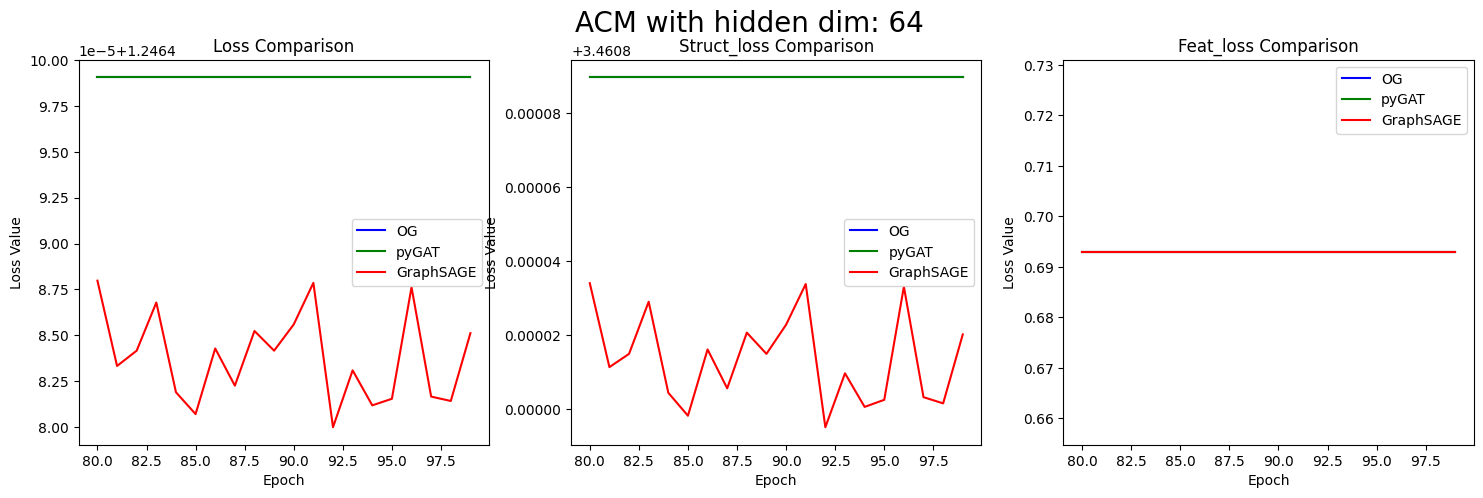

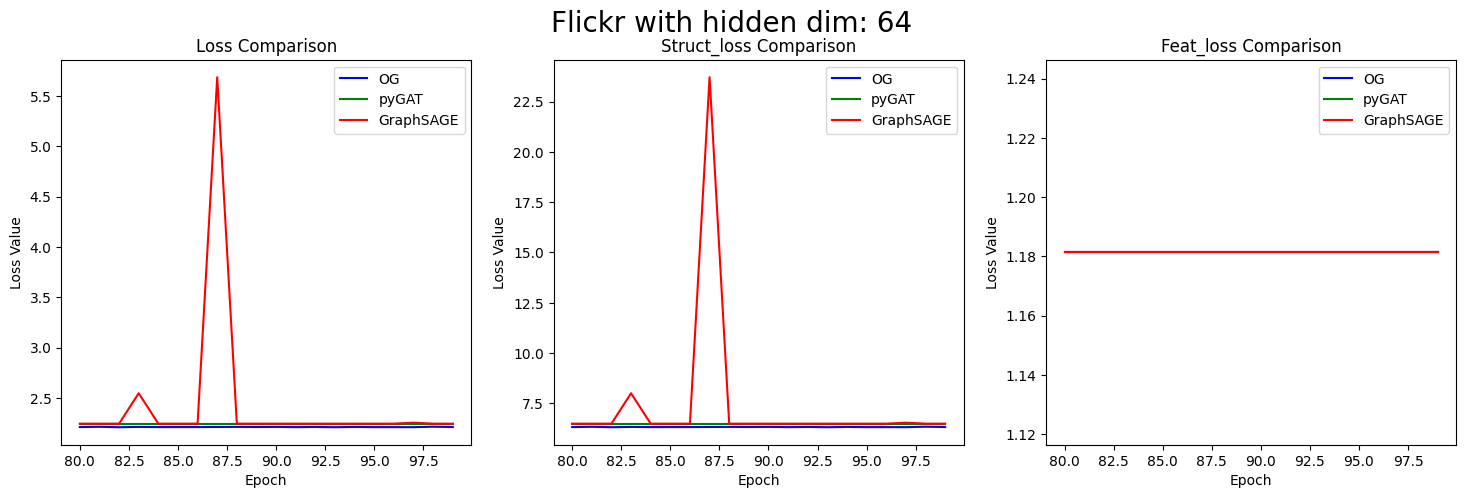

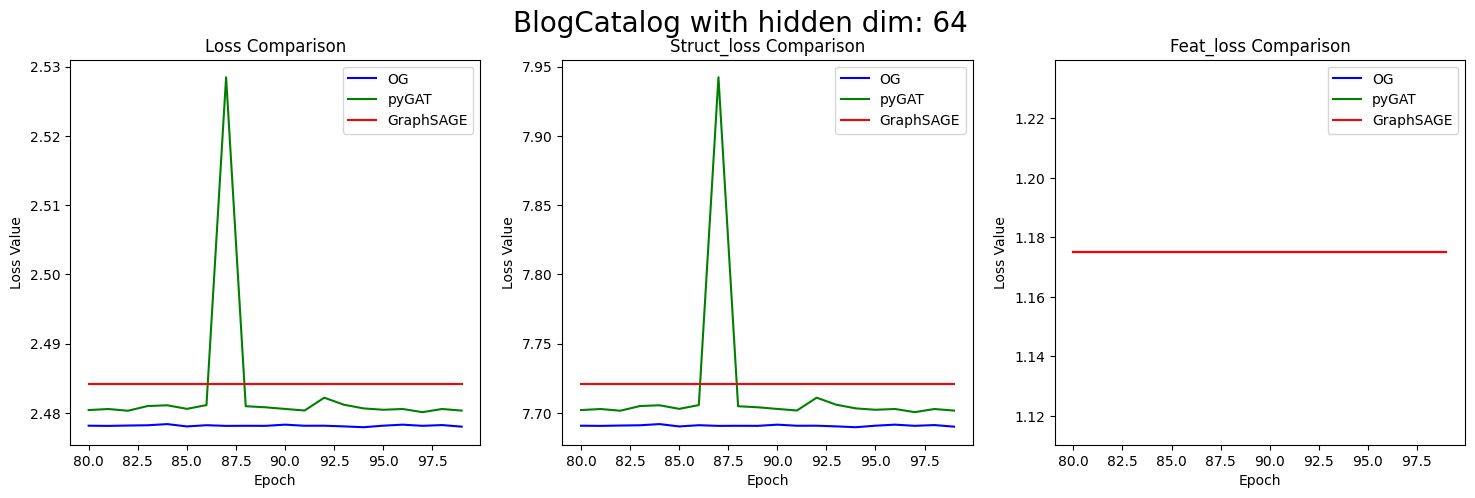

In [574]:
foobar(epoch_300_response)

In [120]:
responses_Mar20 = {}

In [121]:
for encoder in encoders:
    responses_Mar20[encoder] = {}
    for dataset in datasets:
        responses_Mar20[encoder][dataset] = {}
        for hidden_dim in [64]:
            print("encoder: {} dataset: {} hidden_dim: {}".format(encoder, dataset, hidden_dim))
            responses_Mar20[encoder][dataset][hidden_dim] = {}
            curr_res = train_dominant(encoder=encoder, dataset=dataset, hidden_dim=hidden_dim, 
                                      max_epoch=100, lr=5e-2, dropout=0.3, alpha=0.8, device="mps")
            responses_Mar20[encoder][dataset][hidden_dim] = curr_res
            print("time taken: {}\n".format(curr_res["time_elapsed"]))

encoder: OG dataset: ACM hidden_dim: 64
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= 1.24650 train/struct_loss= 3.46089 train/feat_loss= 0.69290 Auc 0.8967425301324609
time taken: 2123735783000

encoder: OG dataset: Flickr hidden_dim: 64
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= 2.21202 train/struct_loss= 6.33439 train/feat_loss= 1.18143 Auc 0.7950410514206472
time taken: 657091634000

encoder: OG dataset: BlogCatalog hidden_dim: 64
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= 2.48409 train/struct_loss= 7.72046 train/feat_loss= 1.17500 Auc 0.8130534035258878
time taken: 252668920000

encoder: pyGGAT dataset: ACM hidden_dim: 64
Epoch: 0000
Epoch: 0010
Epoch

In [128]:
old_responses = responses

In [129]:
old_responses

{'OG': {'ACM': {32: {'loss_dict': {'struct_loss': [46.868896484375,
      3.6572282314300537,
      3.488870143890381,
      3.4608545303344727,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      5.140565872192383,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006,
      3.4608895778656006

In [132]:
old_responses["OG"]["BlogCatalog"][64]

{'loss_dict': {'struct_loss': [16.665626525878906,
   54.92012405395508,
   7.692098617553711,
   7.682213306427002,
   7.670032978057861,
   7.765125751495361,
   7.676119327545166,
   7.707545280456543,
   7.715394020080566,
   7.703930377960205,
   7.672044277191162,
   7.798850059509277,
   7.674290657043457,
   7.706274032592773,
   7.718849182128906,
   7.720041751861572,
   7.720097064971924,
   7.720237731933594,
   7.720149993896484,
   7.720093250274658,
   7.720108985900879,
   7.720072269439697,
   7.719947814941406,
   7.719226837158203,
   7.7189040184021,
   7.715675354003906,
   7.707928657531738,
   7.679780006408691,
   7.727733612060547,
   7.6713547706604,
   7.683988571166992,
   7.6691083908081055,
   7.756808280944824,
   7.672756195068359,
   7.700035095214844,
   7.71687126159668,
   7.720315933227539,
   7.720461845397949,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422

In [141]:
responses["GraphSAGE"]["BlogCatalog"][64]['auc']

0.8130534035258878

In [151]:
dims = [32, 64, 128, 256, 512, 1024]
encoders = ["OG", "pyGGAT", "GraphSAGE"]
datasets = ["ACM", "Flickr", "BlogCatalog"]
hidden_dims = [32, 64, 128, 256, 512, 1024]
max_epochs = [100]
lrs = [5e-3]

auc_scores = {}

for dataset in datasets:
    auc_scores[dataset] = {}
    for encoder in encoders:
        auc_scores[dataset][encoder] = []
        for dim in dims:
            auc_scores[dataset][encoder].append(responses[encoder][dataset][dim]['auc'])

    auc_scores[dataset] = np.column_stack(list(auc_scores[dataset].values()))

In [152]:
auc_scores

{'ACM': array([[0.89674253, 0.89674253, 0.89674253],
        [0.89674253, 0.89668813, 0.89674264],
        [0.89674253, 0.89674253, 0.89674253],
        [0.89674253, 0.89454522, 0.89674253],
        [0.89674253, 0.89526665, 0.89674253],
        [0.89674253, 0.89674253, 0.89667959]]),
 'Flickr': array([[0.79231464, 0.78988417, 0.78988417],
        [0.79460012, 0.78988417, 0.79055612],
        [0.79371827, 0.78988417, 0.78988417],
        [0.78988417, 0.78988417, 0.78988417],
        [0.79271444, 0.78988417, 0.78975275],
        [0.79314701, 0.78988417, 0.78982587]]),
 'BlogCatalog': array([[0.8130534 , 0.8130534 , 0.81348777],
        [0.8130534 , 0.8130534 , 0.8130534 ],
        [0.8130534 , 0.81246146, 0.81343775],
        [0.8130534 , 0.8130534 , 0.8130534 ],
        [0.8130534 , 0.8130534 , 0.8130534 ],
        [0.81314863, 0.8130534 , 0.8130534 ]])}

In [182]:
import matplotlib.pyplot as plt
import numpy as np


def plot_auc_scores(auc_scores, data):

    settings = [32, 64, 128, 256, 512, 1024]
    encoder = ["OG", "pyGGAT", "GraphSAGE"]
    for i in range(len(encoder)):
        plt.plot(settings, auc_scores[:, i], marker='o', label=encoder[i])

    plt.xlabel('Hidden dim')
    plt.ylabel('AUC Score')
    plt.title('AUC Scores of Encoders for {}'.format(data))
    plt.legend()
    plt.xticks(rotation=45)  # Rotate setting names for better readability
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()


In [36]:
responses["OG"]["BlogCatalog"][1024]

{'loss_dict': {'struct_loss': [17.176401138305664,
   2739456.0,
   9737.3525390625,
   7.7190327644348145,
   66.7503662109375,
   7.690749168395996,
   18.67632484436035,
   7.72046422958374,
   7.72046422958374,
   19.988027572631836,
   7.720378875732422,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.695245742797852,
   58.92751693725586,
   7.695923805236816,
   7.719907760620117,
   31.464717864990234,
   7.720430374145508,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374,
   7.72046422958374

In [169]:
len(responses["OG"]["BlogCatalog"][64]["PR_curve"]["recall"])

5194

In [170]:
x = responses["OG"]["BlogCatalog"][64]["PR_curve"]["recall"]

In [181]:
x.sort()
x[1000]

0.6241610738255033

In [17]:
OG_response = train_dominant(encoder="OG",dataset="BlogCatalog", hidden_dim=128, max_epoch=100, lr=5e-2, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 3.72692 train/struct_loss= 13.59083 train/feat_loss= 1.26095 Auc 0.7864091904379543
Epoch: 0010 train_loss= 2.48660 train/struct_loss= 7.73302 train/feat_loss= 1.17500 Auc 0.8138385479897287
Epoch: 0020 train_loss= 2.48437 train/struct_loss= 7.72187 train/feat_loss= 1.17500 Auc 0.8137131715177542
Epoch: 0030 train_loss= 2.47791 train/struct_loss= 7.68957 train/feat_loss= 1.17500 Auc 0.8132428384685162
Epoch: 0040 train_loss= 2.47668 train/struct_loss= 7.68338 train/feat_loss= 1.17500 Auc 0.8136138295044409
Epoch: 0050 train_loss= 2.47490 train/struct_loss= 7.67451 train/feat_loss= 1.17500 Auc 0.8133048415871702
Epoch: 0060 train_loss= 2.47569 train/struct_loss= 7.67844 train/feat_loss= 1.17500 Auc 0.8135720373471163
Epoch: 0070 train_loss= 2.47492 train/struct_loss= 7.67461 train/feat_loss= 1.17500 Auc 0.8136021825097767
Epoch: 0080 train_loss= 2.47529 train/struct_loss= 7.67645 train/feat_loss= 1.17500 Auc 0.813723448277752
Epoch: 0090 train_loss= 2.47531 train

In [111]:
heads_arr = [1, 2, 3]
add_self_loops_arr = [False, True]
fill_value_arr = ["add", "mean", "min", "max", "mul"]
bias_arr = [False, True]

heads_responses = []
for heads in heads_arr:
    print("iterating heads: ", heads)
    curr_res = train_dominant(encoder="pyGGAT", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, heads=heads,
                   dropout=0.3, alpha=0.8, device="mps")
    print("time taken: {}\n".format(curr_res["time_elapsed"]))
    heads_responses.append(curr_res)

    
add_self_loops_responses = []
for add_self_loops in add_self_loops_arr:
    print("iterating add_self_loops: ", add_self_loops)
    curr_res = train_dominant(encoder="pyGGAT", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, add_self_loops=add_self_loops,
                   dropout=0.3, alpha=0.8, device="mps")
    print("time taken: {}\n".format(curr_res["time_elapsed"]))
    add_self_loops_responses.append(curr_res)
    
fill_value_responses = []
for fill_value in fill_value_arr:
    print("iterating fill_value: ", fill_value)
    curr_res = train_dominant(encoder="pyGGAT", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, fill_value=fill_value,
                   dropout=0.3, alpha=0.8, device="mps")
    print("time taken: {}\n".format(curr_res["time_elapsed"]))
    fill_value_responses.append(curr_res)

bias_responses = []
for bias in bias_arr:
    print("iterating bias_arr: ", bias)
    curr_res = train_dominant(encoder="pyGGAT", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, bias=bias,
                   dropout=0.3, alpha=0.8, device="mps")
    print("time taken: {}\n".format(curr_res["time_elapsed"]))
    bias_responses.append(curr_res)

iterating heads:  1
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= 2.47458 train/struct_loss= 7.67502 train/feat_loss= 1.17447 Auc 0.8138173093523997
time taken: 384752436000

iterating heads:  2
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= 2.48369 train/struct_loss= 7.72037 train/feat_loss= 1.17453 Auc 0.813064365403219
time taken: 386416224000

iterating heads:  3
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch: 0090
Epoch: 0099
Epoch: 0099 train_loss= 2.46820 train/struct_loss= 7.64221 train/feat_loss= 1.17470 Auc 0.8141557573149978
time taken: 383840481000

iterating add_self_loops:  False
Epoch: 0000
Epoch: 0010
Epoch: 0020
Epoch: 0030
Epoch: 0040
Epoch: 0050
Epoch: 0060
Epoch: 0070
Epoch: 0080
Epoch

In [553]:
for resp in fill_value_responses:
    

[{'loss_dict': {'struct_loss': [12.963484764099121,
    9.552131652832031,
    7.735358238220215,
    7.657479763031006,
    7.849686622619629,
    7.657414436340332,
    7.696993350982666,
    7.713543891906738,
    7.717426300048828,
    7.7128095626831055,
    7.682880401611328,
    7.712356090545654,
    7.6570143699646,
    7.655891418457031,
    7.696551322937012,
    7.656764030456543,
    7.663671016693115,
    7.670715808868408,
    7.660217761993408,
    7.656545639038086,
    7.686246871948242,
    7.671759128570557,
    7.67891788482666,
    7.686275482177734,
    7.660359859466553,
    7.667976379394531,
    7.674619674682617,
    7.668814659118652,
    7.6739325523376465,
    7.66332483291626,
    7.663933753967285,
    7.670070648193359,
    7.660479545593262,
    7.665910243988037,
    7.662500858306885,
    7.665222644805908,
    7.663710594177246,
    7.660466194152832,
    7.663425922393799,
    7.660200595855713,
    7.660066604614258,
    7.661025524139404,
    7.6

In [52]:
GraphSAGE_response = train_dominant(encoder="GraphSAGE",dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

KeyboardInterrupt: 

In [51]:
GraphSAGE_response

NameError: name 'GraphSAGE_response' is not defined

In [31]:
len(OG_response["loss_dict"]["loss"][1])

5196

In [ ]:
GAT_response = train_dominant(encoder="GAT", dataset="BlogCatalog", hidden_dim=32, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

In [1]:
DenseGAT_response = train_dominant(encoder="DenseGAT", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

NameError: name 'train_dominant' is not defined

In [ ]:
DenseSAGE_response = train_dominant(encoder="DenseSage", dataset="BlogCatalog", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

In [13]:
train_dominant(dataset="BlogCatalog", hidden_dim=64, max_epoch=500, lr=5e-4, dropout=0.3, alpha=0.8, device="cpu")

Epoch: 0000 train_loss= 3.80194 train/struct_loss= 13.96719 train/feat_loss= 1.26063
Epoch: 0000 Auc 0.8076820836336431
Epoch: 0001 train_loss= 3.63766 train/struct_loss= 13.25442 train/feat_loss= 1.23347
Epoch: 0002 train_loss= 3.53396 train/struct_loss= 12.81713 train/feat_loss= 1.21317
Epoch: 0003 train_loss= 3.41595 train/struct_loss= 12.28494 train/feat_loss= 1.19870
Epoch: 0004 train_loss= 3.30913 train/struct_loss= 11.79079 train/feat_loss= 1.18872
Epoch: 0005 train_loss= 3.22164 train/struct_loss= 11.37924 train/feat_loss= 1.18224
Epoch: 0006 train_loss= 3.14188 train/struct_loss= 10.99608 train/feat_loss= 1.17834
Epoch: 0007 train_loss= 3.07212 train/struct_loss= 10.65597 train/feat_loss= 1.17615
Epoch: 0008 train_loss= 2.99504 train/struct_loss= 10.27493 train/feat_loss= 1.17507
Epoch: 0009 train_loss= 2.93523 train/struct_loss= 9.97784 train/feat_loss= 1.17458
Epoch: 0010 train_loss= 2.87493 train/struct_loss= 9.67710 train/feat_loss= 1.17438
Epoch: 0010 Auc 0.80831581716684

Epoch: 0094 train_loss= 2.46428 train/struct_loss= 7.62543 train/feat_loss= 1.17400
Epoch: 0095 train_loss= 2.46446 train/struct_loss= 7.62631 train/feat_loss= 1.17400
Epoch: 0096 train_loss= 2.46435 train/struct_loss= 7.62578 train/feat_loss= 1.17399
Epoch: 0097 train_loss= 2.46421 train/struct_loss= 7.62509 train/feat_loss= 1.17399
Epoch: 0098 train_loss= 2.46424 train/struct_loss= 7.62525 train/feat_loss= 1.17399
Epoch: 0099 train_loss= 2.46420 train/struct_loss= 7.62506 train/feat_loss= 1.17399
Epoch: 0100 train_loss= 2.46437 train/struct_loss= 7.62591 train/feat_loss= 1.17399
Epoch: 0100 Auc 0.81424310977498
Epoch: 0101 train_loss= 2.46432 train/struct_loss= 7.62566 train/feat_loss= 1.17399
Epoch: 0102 train_loss= 2.46430 train/struct_loss= 7.62555 train/feat_loss= 1.17399
Epoch: 0103 train_loss= 2.46438 train/struct_loss= 7.62595 train/feat_loss= 1.17399
Epoch: 0104 train_loss= 2.46415 train/struct_loss= 7.62481 train/feat_loss= 1.17399
Epoch: 0105 train_loss= 2.46423 train/struc

Epoch: 0188 train_loss= 2.46348 train/struct_loss= 7.62169 train/feat_loss= 1.17393
Epoch: 0189 train_loss= 2.46333 train/struct_loss= 7.62091 train/feat_loss= 1.17393
Epoch: 0190 train_loss= 2.46346 train/struct_loss= 7.62160 train/feat_loss= 1.17393
Epoch: 0190 Auc 0.8143475901682923
Epoch: 0191 train_loss= 2.46331 train/struct_loss= 7.62085 train/feat_loss= 1.17393
Epoch: 0192 train_loss= 2.46333 train/struct_loss= 7.62093 train/feat_loss= 1.17393
Epoch: 0193 train_loss= 2.46315 train/struct_loss= 7.62006 train/feat_loss= 1.17393
Epoch: 0194 train_loss= 2.46318 train/struct_loss= 7.62020 train/feat_loss= 1.17393
Epoch: 0195 train_loss= 2.46322 train/struct_loss= 7.62041 train/feat_loss= 1.17393
Epoch: 0196 train_loss= 2.46329 train/struct_loss= 7.62076 train/feat_loss= 1.17393
Epoch: 0197 train_loss= 2.46322 train/struct_loss= 7.62041 train/feat_loss= 1.17393
Epoch: 0198 train_loss= 2.46355 train/struct_loss= 7.62207 train/feat_loss= 1.17393
Epoch: 0199 train_loss= 2.46353 train/str

Epoch: 0282 train_loss= 2.46259 train/struct_loss= 7.61745 train/feat_loss= 1.17388
Epoch: 0283 train_loss= 2.46259 train/struct_loss= 7.61744 train/feat_loss= 1.17387
Epoch: 0284 train_loss= 2.46251 train/struct_loss= 7.61707 train/feat_loss= 1.17387
Epoch: 0285 train_loss= 2.46260 train/struct_loss= 7.61750 train/feat_loss= 1.17387
Epoch: 0286 train_loss= 2.46252 train/struct_loss= 7.61713 train/feat_loss= 1.17387
Epoch: 0287 train_loss= 2.46256 train/struct_loss= 7.61729 train/feat_loss= 1.17387
Epoch: 0288 train_loss= 2.46261 train/struct_loss= 7.61758 train/feat_loss= 1.17387
Epoch: 0289 train_loss= 2.46255 train/struct_loss= 7.61726 train/feat_loss= 1.17387
Epoch: 0290 train_loss= 2.46237 train/struct_loss= 7.61640 train/feat_loss= 1.17387
Epoch: 0290 Auc 0.8145113332109257
Epoch: 0291 train_loss= 2.46237 train/struct_loss= 7.61639 train/feat_loss= 1.17387
Epoch: 0292 train_loss= 2.46248 train/struct_loss= 7.61695 train/feat_loss= 1.17387
Epoch: 0293 train_loss= 2.46237 train/str

Epoch: 0376 train_loss= 2.46198 train/struct_loss= 7.61477 train/feat_loss= 1.17379
Epoch: 0377 train_loss= 2.46193 train/struct_loss= 7.61450 train/feat_loss= 1.17379
Epoch: 0378 train_loss= 2.46205 train/struct_loss= 7.61510 train/feat_loss= 1.17379
Epoch: 0379 train_loss= 2.46192 train/struct_loss= 7.61446 train/feat_loss= 1.17378
Epoch: 0380 train_loss= 2.46209 train/struct_loss= 7.61534 train/feat_loss= 1.17378
Epoch: 0380 Auc 0.8146168412802377
Epoch: 0381 train_loss= 2.46189 train/struct_loss= 7.61433 train/feat_loss= 1.17378
Epoch: 0382 train_loss= 2.46211 train/struct_loss= 7.61544 train/feat_loss= 1.17378
Epoch: 0383 train_loss= 2.46219 train/struct_loss= 7.61583 train/feat_loss= 1.17378
Epoch: 0384 train_loss= 2.46219 train/struct_loss= 7.61582 train/feat_loss= 1.17378
Epoch: 0385 train_loss= 2.46207 train/struct_loss= 7.61522 train/feat_loss= 1.17378
Epoch: 0386 train_loss= 2.46199 train/struct_loss= 7.61483 train/feat_loss= 1.17378
Epoch: 0387 train_loss= 2.46194 train/str

Epoch: 0470 train_loss= 2.46149 train/struct_loss= 7.61271 train/feat_loss= 1.17368
Epoch: 0470 Auc 0.8146600036722289
Epoch: 0471 train_loss= 2.46166 train/struct_loss= 7.61359 train/feat_loss= 1.17368
Epoch: 0472 train_loss= 2.46147 train/struct_loss= 7.61262 train/feat_loss= 1.17368
Epoch: 0473 train_loss= 2.46149 train/struct_loss= 7.61276 train/feat_loss= 1.17368
Epoch: 0474 train_loss= 2.46156 train/struct_loss= 7.61307 train/feat_loss= 1.17368
Epoch: 0475 train_loss= 2.46140 train/struct_loss= 7.61232 train/feat_loss= 1.17368
Epoch: 0476 train_loss= 2.46159 train/struct_loss= 7.61321 train/feat_loss= 1.17368
Epoch: 0477 train_loss= 2.46152 train/struct_loss= 7.61292 train/feat_loss= 1.17368
Epoch: 0478 train_loss= 2.46150 train/struct_loss= 7.61282 train/feat_loss= 1.17367
Epoch: 0479 train_loss= 2.46142 train/struct_loss= 7.61237 train/feat_loss= 1.17368
Epoch: 0480 train_loss= 2.46165 train/struct_loss= 7.61354 train/feat_loss= 1.17368
Epoch: 0480 Auc 0.8146702804322268
Epoch:

In [19]:
train_dominant(dataset="BlogCatalog", hidden_dim=64, max_epoch=500, lr=5e-2, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 4.34323 train/struct_loss= 16.68764 train/feat_loss= 1.25712
Epoch: 0000 Auc 0.6479319048180192
Epoch: 0001 train_loss= 14.08281 train/struct_loss= 52.20726 train/feat_loss= 4.55171
Epoch: 0002 train_loss= 2.67803 train/struct_loss= 7.71949 train/feat_loss= 1.41767
Epoch: 0003 train_loss= 2.50623 train/struct_loss= 7.68096 train/feat_loss= 1.21255
Epoch: 0004 train_loss= 2.47950 train/struct_loss= 7.67807 train/feat_loss= 1.17986
Epoch: 0005 train_loss= 2.51940 train/struct_loss= 7.88895 train/feat_loss= 1.17702
Epoch: 0006 train_loss= 2.47858 train/struct_loss= 7.68228 train/feat_loss= 1.17765
Epoch: 0007 train_loss= 2.48236 train/struct_loss= 7.71183 train/feat_loss= 1.17500
Epoch: 0008 train_loss= 2.47954 train/struct_loss= 7.69773 train/feat_loss= 1.17500
Epoch: 0009 train_loss= 2.47969 train/struct_loss= 7.69844 train/feat_loss= 1.17500
Epoch: 0010 train_loss= 2.47787 train/struct_loss= 7.68937 train/feat_loss= 1.17500
Epoch: 0010 Auc 0.8133027862351705
Epo

Epoch: 0094 train_loss= 2.47205 train/struct_loss= 7.66024 train/feat_loss= 1.17500
Epoch: 0095 train_loss= 2.47147 train/struct_loss= 7.65734 train/feat_loss= 1.17500
Epoch: 0096 train_loss= 2.47184 train/struct_loss= 7.65922 train/feat_loss= 1.17500
Epoch: 0097 train_loss= 2.47201 train/struct_loss= 7.66006 train/feat_loss= 1.17500
Epoch: 0098 train_loss= 2.47163 train/struct_loss= 7.65815 train/feat_loss= 1.17500
Epoch: 0099 train_loss= 2.47213 train/struct_loss= 7.66067 train/feat_loss= 1.17500
Epoch: 0100 train_loss= 2.47139 train/struct_loss= 7.65697 train/feat_loss= 1.17500
Epoch: 0100 Auc 0.8138474545150602
Epoch: 0101 train_loss= 2.47151 train/struct_loss= 7.65755 train/feat_loss= 1.17500
Epoch: 0102 train_loss= 2.47147 train/struct_loss= 7.65737 train/feat_loss= 1.17500
Epoch: 0103 train_loss= 2.47169 train/struct_loss= 7.65843 train/feat_loss= 1.17500
Epoch: 0104 train_loss= 2.47185 train/struct_loss= 7.65927 train/feat_loss= 1.17500
Epoch: 0105 train_loss= 2.47138 train/str

Epoch: 0188 train_loss= 2.47217 train/struct_loss= 7.66084 train/feat_loss= 1.17500
Epoch: 0189 train_loss= 2.47180 train/struct_loss= 7.65902 train/feat_loss= 1.17500
Epoch: 0190 train_loss= 2.47183 train/struct_loss= 7.65915 train/feat_loss= 1.17500
Epoch: 0190 Auc 0.8138597866270577
Epoch: 0191 train_loss= 2.47165 train/struct_loss= 7.65827 train/feat_loss= 1.17500
Epoch: 0192 train_loss= 2.47161 train/struct_loss= 7.65805 train/feat_loss= 1.17500
Epoch: 0193 train_loss= 2.47175 train/struct_loss= 7.65877 train/feat_loss= 1.17500
Epoch: 0194 train_loss= 2.47164 train/struct_loss= 7.65820 train/feat_loss= 1.17500
Epoch: 0195 train_loss= 2.47195 train/struct_loss= 7.65976 train/feat_loss= 1.17500
Epoch: 0196 train_loss= 2.47151 train/struct_loss= 7.65757 train/feat_loss= 1.17500
Epoch: 0197 train_loss= 2.47179 train/struct_loss= 7.65893 train/feat_loss= 1.17500
Epoch: 0198 train_loss= 2.47197 train/struct_loss= 7.65988 train/feat_loss= 1.17500
Epoch: 0199 train_loss= 2.47204 train/str

Epoch: 0282 train_loss= 2.47213 train/struct_loss= 7.66068 train/feat_loss= 1.17500
Epoch: 0283 train_loss= 2.47224 train/struct_loss= 7.66119 train/feat_loss= 1.17500
Epoch: 0284 train_loss= 2.47227 train/struct_loss= 7.66137 train/feat_loss= 1.17500
Epoch: 0285 train_loss= 2.47183 train/struct_loss= 7.65918 train/feat_loss= 1.17500
Epoch: 0286 train_loss= 2.47224 train/struct_loss= 7.66123 train/feat_loss= 1.17500
Epoch: 0287 train_loss= 2.47175 train/struct_loss= 7.65877 train/feat_loss= 1.17500
Epoch: 0288 train_loss= 2.47148 train/struct_loss= 7.65742 train/feat_loss= 1.17500
Epoch: 0289 train_loss= 2.47158 train/struct_loss= 7.65793 train/feat_loss= 1.17500
Epoch: 0290 train_loss= 2.47206 train/struct_loss= 7.66031 train/feat_loss= 1.17500
Epoch: 0290 Auc 0.8138412884590616
Epoch: 0291 train_loss= 2.47155 train/struct_loss= 7.65777 train/feat_loss= 1.17500
Epoch: 0292 train_loss= 2.47176 train/struct_loss= 7.65882 train/feat_loss= 1.17500
Epoch: 0293 train_loss= 2.47141 train/str

Epoch: 0376 train_loss= 2.47150 train/struct_loss= 7.65752 train/feat_loss= 1.17500
Epoch: 0377 train_loss= 2.47175 train/struct_loss= 7.65876 train/feat_loss= 1.17500
Epoch: 0378 train_loss= 2.47133 train/struct_loss= 7.65664 train/feat_loss= 1.17500
Epoch: 0379 train_loss= 2.47205 train/struct_loss= 7.66025 train/feat_loss= 1.17500
Epoch: 0380 train_loss= 2.47189 train/struct_loss= 7.65947 train/feat_loss= 1.17500
Epoch: 0380 Auc 0.8138522503363925
Epoch: 0381 train_loss= 2.47227 train/struct_loss= 7.66134 train/feat_loss= 1.17500
Epoch: 0382 train_loss= 2.47151 train/struct_loss= 7.65757 train/feat_loss= 1.17500
Epoch: 0383 train_loss= 2.47147 train/struct_loss= 7.65736 train/feat_loss= 1.17500
Epoch: 0384 train_loss= 2.47191 train/struct_loss= 7.65957 train/feat_loss= 1.17500
Epoch: 0385 train_loss= 2.47161 train/struct_loss= 7.65805 train/feat_loss= 1.17500
Epoch: 0386 train_loss= 2.47198 train/struct_loss= 7.65989 train/feat_loss= 1.17500
Epoch: 0387 train_loss= 2.47192 train/str

Epoch: 0470 train_loss= 2.47165 train/struct_loss= 7.65825 train/feat_loss= 1.17500
Epoch: 0470 Auc 0.81378305348574
Epoch: 0471 train_loss= 2.47162 train/struct_loss= 7.65810 train/feat_loss= 1.17500
Epoch: 0472 train_loss= 2.47139 train/struct_loss= 7.65695 train/feat_loss= 1.17500
Epoch: 0473 train_loss= 2.47203 train/struct_loss= 7.66014 train/feat_loss= 1.17500
Epoch: 0474 train_loss= 2.47172 train/struct_loss= 7.65860 train/feat_loss= 1.17500
Epoch: 0475 train_loss= 2.47186 train/struct_loss= 7.65932 train/feat_loss= 1.17500
Epoch: 0476 train_loss= 2.47227 train/struct_loss= 7.66135 train/feat_loss= 1.17500
Epoch: 0477 train_loss= 2.47215 train/struct_loss= 7.66078 train/feat_loss= 1.17500
Epoch: 0478 train_loss= 2.47213 train/struct_loss= 7.66068 train/feat_loss= 1.17500
Epoch: 0479 train_loss= 2.47181 train/struct_loss= 7.65906 train/feat_loss= 1.17500
Epoch: 0480 train_loss= 2.47212 train/struct_loss= 7.66062 train/feat_loss= 1.17500
Epoch: 0480 Auc 0.8138214200563989
Epoch: 0

In [13]:
_, _ = train_dominant(dataset="ACM", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 9.02370 train/struct_loss= 41.35220 train/feat_loss= 0.94157
Epoch: 0000 Auc 0.5681543931655508 precision-recall auc 0.04757547300117436
Epoch: 0001 train_loss= 2.88270 train/struct_loss= 11.61893 train/feat_loss= 0.69864
Epoch: 0002 train_loss= 1.49756 train/struct_loss= 4.71589 train/feat_loss= 0.69297
Epoch: 0003 train_loss= 1.29685 train/struct_loss= 3.71253 train/feat_loss= 0.69293
Epoch: 0004 train_loss= 1.24913 train/struct_loss= 3.47388 train/feat_loss= 0.69295
Epoch: 0005 train_loss= 1.24640 train/struct_loss= 3.46040 train/feat_loss= 0.69290
Epoch: 0006 train_loss= 1.24642 train/struct_loss= 3.46050 train/feat_loss= 0.69290
Epoch: 0007 train_loss= 1.24660 train/struct_loss= 3.46142 train/feat_loss= 0.69290
Epoch: 0008 train_loss= 1.24645 train/struct_loss= 3.46066 train/feat_loss= 0.69290
Epoch: 0009 train_loss= 1.24750 train/struct_loss= 3.46587 train/feat_loss= 0.69290
Epoch: 0010 train_loss= 1.24642 train/struct_loss= 3.46052 train/feat_loss= 0.6929

Epoch: 0090 train_loss= 1.24650 train/struct_loss= 3.46088 train/feat_loss= 0.69290
Epoch: 0090 Auc 0.8967450605664651 precision-recall auc 0.17818718820523552
Epoch: 0091 train_loss= 1.24649 train/struct_loss= 3.46085 train/feat_loss= 0.69290
Epoch: 0092 train_loss= 1.24649 train/struct_loss= 3.46082 train/feat_loss= 0.69290
Epoch: 0093 train_loss= 1.24648 train/struct_loss= 3.46080 train/feat_loss= 0.69290
Epoch: 0094 train_loss= 1.24649 train/struct_loss= 3.46082 train/feat_loss= 0.69290
Epoch: 0095 train_loss= 1.24649 train/struct_loss= 3.46083 train/feat_loss= 0.69290
Epoch: 0096 train_loss= 1.24648 train/struct_loss= 3.46081 train/feat_loss= 0.69290
Epoch: 0097 train_loss= 1.24650 train/struct_loss= 3.46088 train/feat_loss= 0.69290
Epoch: 0098 train_loss= 1.24649 train/struct_loss= 3.46086 train/feat_loss= 0.69290
Epoch: 0099 train_loss= 1.24650 train/struct_loss= 3.46089 train/feat_loss= 0.69290
Epoch: 0099 Auc 0.8967368893733264 precision-recall auc 0.17816073154107862


In [29]:
train_dominant(dataset="Flickr", hidden_dim=64, max_epoch=100, lr=5e-3, dropout=0.3, alpha=0.8, device="mps")

Epoch: 0000 train_loss= 4.63550 train/struct_loss= 18.08544 train/feat_loss= 1.27301
Score:  [11.331537   8.407093   8.669939  ...  3.9367468  4.41934    5.138904 ] Label:  [0 0 0 ... 0 0 0]
Epoch: 0000 Auc 0.7683332020108105 precision-recall auc 0.3199356391805774
Epoch: 0001 train_loss= 3.51235 train/struct_loss= 12.77481 train/feat_loss= 1.19674
Epoch: 0002 train_loss= 2.82027 train/struct_loss= 9.37342 train/feat_loss= 1.18198
Epoch: 0003 train_loss= 2.42017 train/struct_loss= 7.37486 train/feat_loss= 1.18150
Epoch: 0004 train_loss= 2.27135 train/struct_loss= 6.63073 train/feat_loss= 1.18150
Epoch: 0005 train_loss= 2.25135 train/struct_loss= 6.53094 train/feat_loss= 1.18146
Epoch: 0006 train_loss= 2.21896 train/struct_loss= 6.36893 train/feat_loss= 1.18146
Epoch: 0007 train_loss= 2.20871 train/struct_loss= 6.31779 train/feat_loss= 1.18144
Epoch: 0008 train_loss= 2.21536 train/struct_loss= 6.35101 train/feat_loss= 1.18144
Epoch: 0009 train_loss= 2.21940 train/struct_loss= 6.37127 tr

Epoch: 0081 train_loss= 2.20404 train/struct_loss= 6.29452 train/feat_loss= 1.18143
Epoch: 0082 train_loss= 2.20465 train/struct_loss= 6.29754 train/feat_loss= 1.18143
Epoch: 0083 train_loss= 2.20406 train/struct_loss= 6.29458 train/feat_loss= 1.18143
Epoch: 0084 train_loss= 2.20494 train/struct_loss= 6.29898 train/feat_loss= 1.18143
Epoch: 0085 train_loss= 2.20598 train/struct_loss= 6.30419 train/feat_loss= 1.18143
Epoch: 0086 train_loss= 2.20527 train/struct_loss= 6.30064 train/feat_loss= 1.18143
Epoch: 0087 train_loss= 2.20528 train/struct_loss= 6.30070 train/feat_loss= 1.18143
Epoch: 0088 train_loss= 2.20572 train/struct_loss= 6.30288 train/feat_loss= 1.18143
Epoch: 0089 train_loss= 2.20461 train/struct_loss= 6.29735 train/feat_loss= 1.18143
Epoch: 0090 train_loss= 2.20579 train/struct_loss= 6.30322 train/feat_loss= 1.18143
Score:  [11.545618   7.989866   8.279737  ...  1.0738684  1.3293853  1.5575988] Label:  [0 0 0 ... 0 0 0]
Epoch: 0090 Auc 0.7940422648407583 precision-recall au

(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([11.485475 ,  7.91902  ,  8.182805 , ...,  1.0738319,  1.3297378,
         1.5575988], dtype=float32))

In [11]:
list(score)

[5.9199862,
 5.6792407,
 5.6175327,
 5.1550713,
 4.9538846,
 4.836311,
 5.227498,
 4.6503024,
 4.977279,
 5.0427194,
 4.943839,
 5.131177,
 4.764241,
 4.520692,
 4.49689,
 4.58091,
 4.67495,
 4.3855133,
 5.146143,
 4.2798777,
 4.581525,
 4.438023,
 4.5066433,
 4.1719413,
 6.31293,
 4.636311,
 4.546307,
 4.8321476,
 4.524132,
 4.5016265,
 4.614414,
 4.545185,
 5.433449,
 4.325013,
 4.534647,
 5.422137,
 4.414521,
 3.8784897,
 4.209894,
 3.5439591,
 5.1668644,
 4.247705,
 5.4212456,
 4.8509264,
 4.1380873,
 3.7704651,
 6.3601513,
 4.846906,
 4.235647,
 4.4057446,
 4.2171583,
 4.5601144,
 3.8973687,
 3.7481236,
 3.6509554,
 4.605194,
 4.07028,
 3.9284918,
 3.6943047,
 4.2370086,
 4.0126605,
 4.655206,
 4.3142095,
 4.010345,
 4.137539,
 4.562504,
 4.123822,
 4.444492,
 4.242847,
 4.3296175,
 3.492065,
 3.7454042,
 4.0084476,
 4.375434,
 4.383264,
 4.6355844,
 4.2125173,
 3.4031675,
 4.1736345,
 3.8646266,
 3.6871793,
 4.3944035,
 4.058595,
 4.1514316,
 5.416149,
 4.251447,
 3.6457982,
 3.4

In [ ]:
A= [1, 2, 3, 4, 5]
label = [1, 0, 0, 0, 1]
score = [3, 1, 2, 1, 1]

In [5]:
adj = data_mat['Network']
feat = data_mat['Attributes']
truth = data_mat['Label']
truth = truth.flatten()

In [11]:
_, [normal, anomalous] = np.unique(truth, return_counts=True)
print(normal + anomalous)

16484


9.970274205289979

In [8]:
15887 + 597

16484

In [43]:
adj_norm = normalize_adj(adj + sp.eye(adj.shape[0]))


<5196x5196 sparse matrix of type '<class 'numpy.float64'>'
	with 350577 stored elements in COOrdinate format>

In [46]:
adj_norm.toarray()

array([[0.0012987 , 0.00156096, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00156096, 0.00187617, 0.00195477, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00195477, 0.00203666, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0625    , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05263158,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05263158]])

In [47]:
adj_norm = normalize_adj(adj + sp.eye(adj.shape[0]))
adj_norm = adj_norm.toarray()
adj = adj + sp.eye(adj.shape[0])
adj = adj.toarray()
feat = feat.toarray()

In [49]:
adj_norm

array([[0.0012987 , 0.00156096, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00156096, 0.00187617, 0.00195477, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00195477, 0.00203666, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0625    , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05263158,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05263158]])

In [67]:
adj_norm[0][2]

0.0

In [24]:
import numpy as np
from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.34, 0.4, 0.8])
precision, recall, thresholds = precision_recall_curve(
    y_true, y_scores)
print(precision)
print(recall)
print(thresholds)

[0.5        0.66666667 1.         1.         1.        ]
[1.  1.  1.  0.5 0. ]
[0.1  0.34 0.4  0.8 ]


In [ ]:
A = [0, 0, 0, 1, 1]
prob = [3/5, 3/5, 3/5, 2/5, 2/5]

In [27]:
# reading the JSON data using json.load()
file = 'responses.json'

with open(file) as responses_file:
    dict_responses = json.load(responses_file)

# converting json dataset from dictionary to dataframe
responses_df = pd.DataFrame.from_dict(dict_responses, orient='index')
responses_df.reset_index(level=0, inplace=True)

file = 'fingraph_response_8000_nodes.json'

with open(file) as responses_file:
    dict_responses = json.load(responses_file)

# converting json dataset from dictionary to dataframe
fin_df = pd.DataFrame.from_dict(dict_responses, orient='index')
fin_df.reset_index(level=0, inplace=True)

In [65]:
responses_df

,index,ACM,Flickr,BlogCatalog
0,OG,{'64': {'loss_dict': {'struct_loss': [25.41669...,{'64': {'loss_dict': {'struct_loss': [17.47858...,{'64': {'loss_dict': {'struct_loss': [14.81083...
1,pyGGAT,{'64': {'loss_dict': {'struct_loss': [25.19161...,{'64': {'loss_dict': {'struct_loss': [16.23989...,{'64': {'loss_dict': {'struct_loss': [14.66710...
2,GraphSAGE,{'64': {'loss_dict': {'struct_loss': [24.15521...,{'64': {'loss_dict': {'struct_loss': [17.60626...,{'64': {'loss_dict': {'struct_loss': [15.34853...


In [79]:
fin_df

,index,finGraph
0,GraphSAGE,{'64': {'loss_dict': {'struct_loss': [169.9870...
1,OG,{'64': {'loss_dict': {'struct_loss': [129.4018...
2,pyGGAT,{'64': {'loss_dict': {'struct_loss': [63.00945...


In [77]:
fin_dict = {
    0: 1,
    1: 2,
    2: 0
}
def plot_PR_curve():
    for dataset in ["ACM", "Flickr", "BlogCatalog"]:
        recall = []
        precision = []
        for i in range(3):
            recall.append(responses_df.iloc[i][dataset]["64"]["PR_curve"]["recall"])
            precision.append(responses_df.iloc[i][dataset]["64"]["PR_curve"]["precision"])
        recall.append(fin_df.iloc[2]["finGraph"]["64"]["PR_curve"]["recall"])
        precision.append(fin_df.iloc[2]["finGraph"]["64"]["PR_curve"]["precision"])
        
        
        plt.plot(recall[0], precision[0], label='DOMINANT')
        plt.plot(recall[1], precision[1], label='GAT')
        plt.plot(recall[2], precision[2], label='GraphSAGE')

        
        
        plt.plot(recall_model4, precision_model4, label='Model 4')
        
        # Adding labels and title
        plt.ylabel("Precision")
        plt.xlabel("Recall")
        plt.title("Precision-Recall Curves for " + dataset)

        # Adding legend to differentiate between models
        plt.legend()

        # Show the plot
        plt.show()
    

In [57]:
fin_df

,index,finGraph
0,GraphSAGE,{'64': {'loss_dict': {'struct_loss': [169.9870...
1,OG,{'64': {'loss_dict': {'struct_loss': [129.4018...
2,pyGGAT,{'64': {'loss_dict': {'struct_loss': [63.00945...


In [58]:
responses_df

,index,ACM,Flickr,BlogCatalog
0,OG,{'64': {'loss_dict': {'struct_loss': [25.41669...,{'64': {'loss_dict': {'struct_loss': [17.47858...,{'64': {'loss_dict': {'struct_loss': [14.81083...
1,pyGGAT,{'64': {'loss_dict': {'struct_loss': [25.19161...,{'64': {'loss_dict': {'struct_loss': [16.23989...,{'64': {'loss_dict': {'struct_loss': [14.66710...
2,GraphSAGE,{'64': {'loss_dict': {'struct_loss': [24.15521...,{'64': {'loss_dict': {'struct_loss': [17.60626...,{'64': {'loss_dict': {'struct_loss': [15.34853...


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_PR_graph(metric, dataset, model_1, model_2, model_3, model_4=[]):
    K = [50, 100, 200, 300]
    # Width of the bars
    bar_width = 0.2
    index = np.arange(len(K))

    # Create the multibar chart
    plt.bar(index, model_1, bar_width, label='DOMINANT')
    plt.bar(index + bar_width, model_2, bar_width, label='GAT')
    plt.bar(index + 2 * bar_width, model_3, bar_width, label='GraphSAGE')
    if model_4 != []:
        plt.bar(index + 3 * bar_width, model_4, bar_width, label='RGCN')

    # Find the maximum precision value across all models
    all_precisions = model_1[0] + model_2[0] + model_3[0] + model_4[0]
    max_precision = max(all_precisions)

    # Add a horizontal line at the highest precision value
    plt.axhline(y=max_precision, color='r', linestyle='--', label=f'Highest Precision: {max_precision:.3f}')

    # Labels and title
    plt.xlabel('K Values')
    plt.ylabel(metric)
    plt.title(metric + ' Values for ' + dataset)
    plt.xticks(index + 1.5 * bar_width, K)

    # Adding legend
    plt.legend()

    # Show the plot
    plt.show()

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_PR_graph(metric, dataset, model_1, model_2, model_3, model_4=[]):
    K_values = [50, 100, 200, 300]
    
    # Set up the bar width and positions
    bar_width = 0.1
    r1 = np.arange(len(K_values))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
#     # Plot bars for each model
#     plt.bar(r1, model_1, width=bar_width, label='Dominant Set', color='blue', alpha=0.8)
#     plt.bar(r2, model_2, width=bar_width, label='GAT', color='green', alpha=0.8)
#     plt.bar(r3, model_3, width=bar_width, label='GraphSAGE', color='red', alpha=0.8)
    
#     if model_4:
#         plt.bar(r4, model_4, width=bar_width, label='RGCN', color='purple', alpha=0.8)
    
        # Plot bars for each model
    plt.bar(r1, model_1, width=bar_width, label='Dominant', alpha=0.8)
    plt.bar(r2, model_2, width=bar_width, label='GAT', alpha=0.8)
    plt.bar(r3, model_3, width=bar_width, label='GraphSAGE', alpha=0.8)
    
    if model_4:
        plt.bar(r4, model_4, width=bar_width, label='RGCN', alpha=0.8)
    
    # Add labels and title
    plt.xlabel('K')
    plt.ylabel(metric)
    plt.title(f'{metric}@K for {dataset} Dataset')
    plt.xticks([r + bar_width for r in range(len(K_values))], K_values)
    
    # Add legend
    plt.legend()
    
    # Find the highest value and corresponding model
    all_values = model_1 + model_2 + model_3 + model_4
    print(all_values)
    max_value = max(all_values)
    max_index = all_values.index(max_value)
    
    model_names = ['Dominant', 'GAT', 'GraphSAGE', 'RGCN']
    max_model = model_names[max_index // len(K_values)]
    if max_model == 'Dominant':
        max_model = 'GraphSAGE'
    # Add horizontal dotted line for the highest value
    plt.axhline(y=max_value, color='gray', linestyle=':', linewidth=2)
    
    # Add text to call out the highest value and model
    plt.text(len(K_values) - 1, max_value, f'Highest: {max_value:.3f} ({max_model})', 
             verticalalignment='bottom', horizontalalignment='right')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

[0.68, 0.67, 0.66, 0.66, 0.68, 0.67, 0.66, 0.66, 0.68, 0.67, 0.66, 0.66]


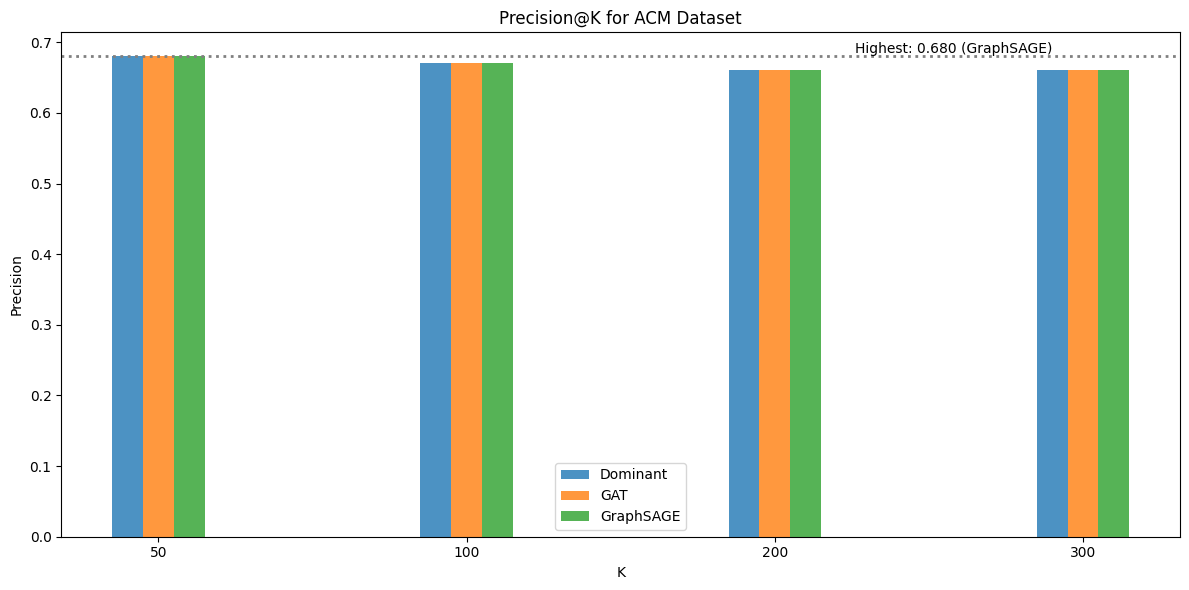

[0.493, 0.54, 0.61, 0.7, 0.493, 0.54, 0.61, 0.7, 0.497, 0.6, 0.61, 0.7]


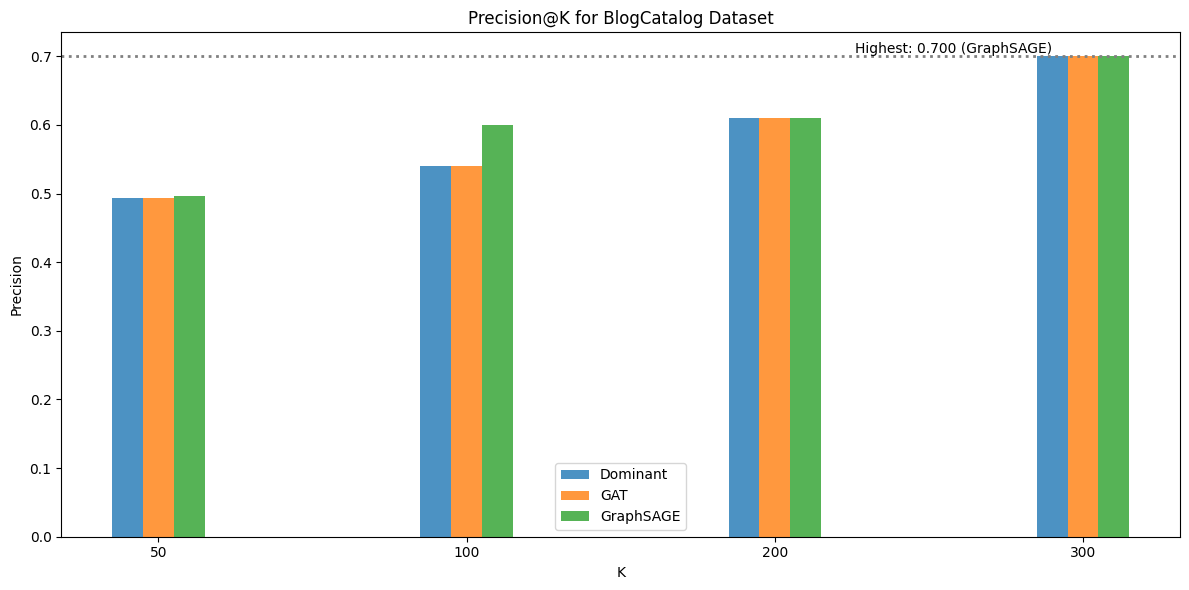

[0.5, 0.67, 0.68, 0.627, 0.62, 0.72, 0.705, 0.647, 0.48, 0.67, 0.68, 0.623]


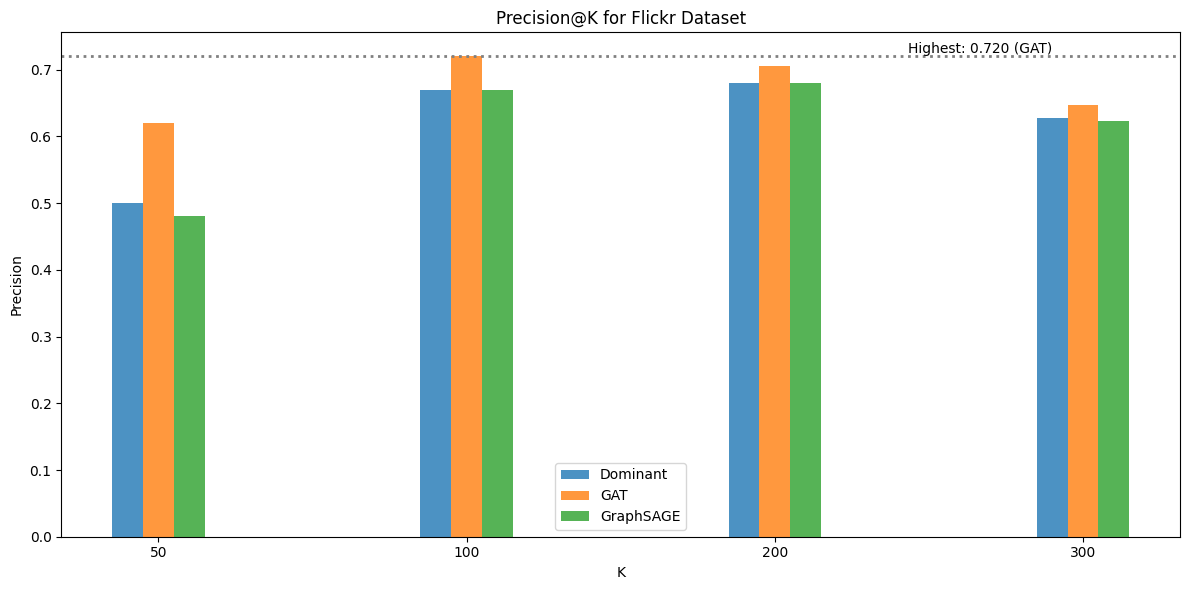

[0.52, 0.56, 0.545, 0.533, 0.54, 0.54, 0.535, 0.53, 0.56, 0.56, 0.545, 0.53, 0.64, 0.61, 0.58, 0.597]


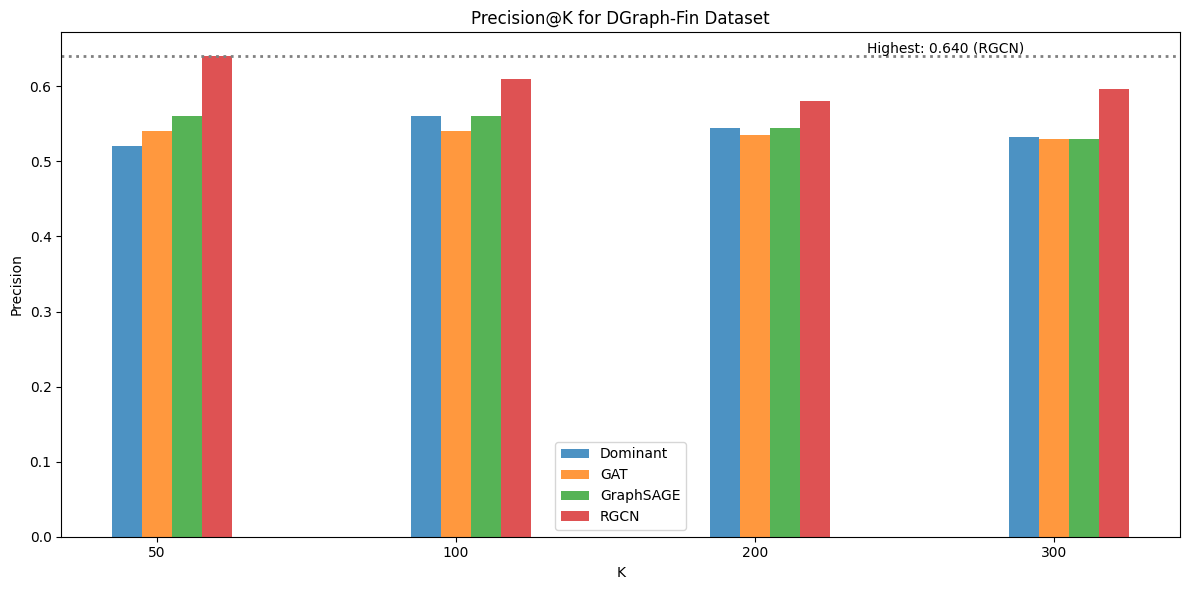

In [31]:
# plot Precision graphs
title = "Precision"
dominant_ACM = [0.68, 0.67, 0.66, 0.66]
gat_ACM = [0.68, 0.67, 0.66, 0.66]
graphSAGE_ACM = [0.68, 0.67, 0.66, 0.66]

plot_PR_graph(title, "ACM", dominant_ACM, gat_ACM, graphSAGE_ACM)

dominant_Blog = [0.493, 0.54, 0.61, 0.7]
gat_Blog = [0.493, 0.54, 0.61, 0.7]
graphSAGE_Blog = [0.497, 0.60, 0.61, 0.7]

plot_PR_graph(title, "BlogCatalog", dominant_Blog, gat_Blog, graphSAGE_Blog)

dominant_Flickr = [0.5, 0.67, 0.680, 0.627]
gat_Flickr = [0.62, 0.72, 0.705, 0.647]
graphSAGE_Flickr = [0.48, 0.67, 0.680, 0.623]


plot_PR_graph(title, "Flickr", dominant_Flickr, gat_Flickr, graphSAGE_Flickr)

dominant_Fin = [0.52, 0.56, 0.545, 0.533]
gat_Fin = [0.54, 0.54, 0.535, 0.53]
graphSAGE_Fin = [0.56, 0.56, 0.545, 0.53]
RGCN_Fin = [0.64, 0.61, 0.58, 0.597]

plot_PR_graph(title, "DGraph-Fin", dominant_Fin, gat_Fin, graphSAGE_Fin, RGCN_Fin)

[0.613, 0.627, 0.657, 0.69, 0.613, 0.627, 0.657, 0.69, 0.613, 0.627, 0.657, 0.69]


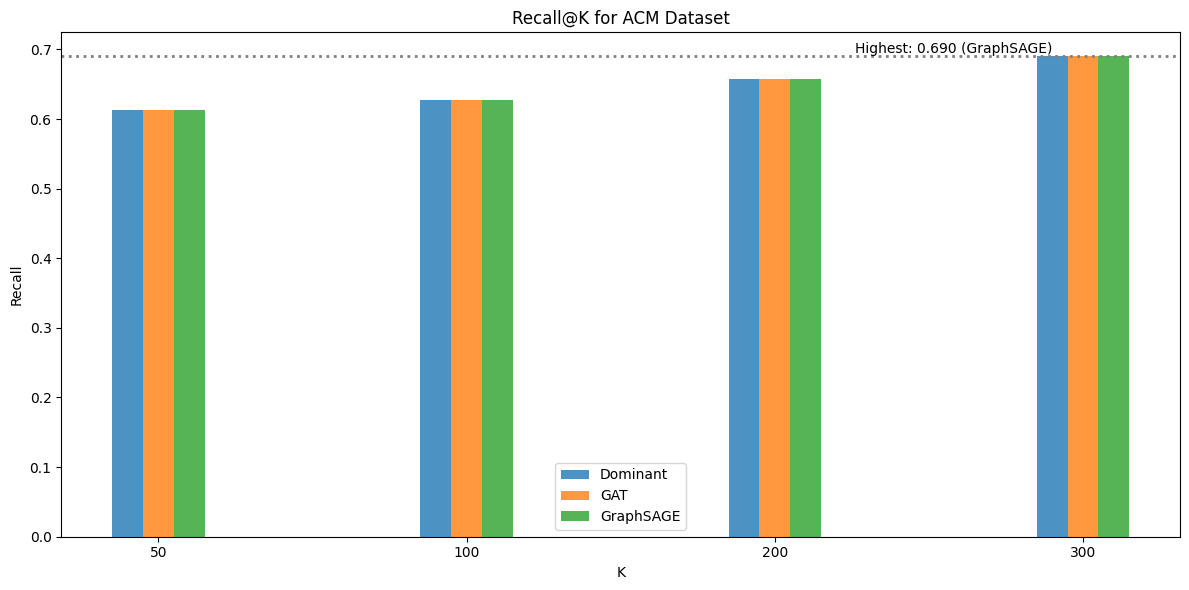

[0.517, 0.605, 0.729, 0.791, 0.517, 0.605, 0.729, 0.791, 0.517, 0.605, 0.73, 0.796]


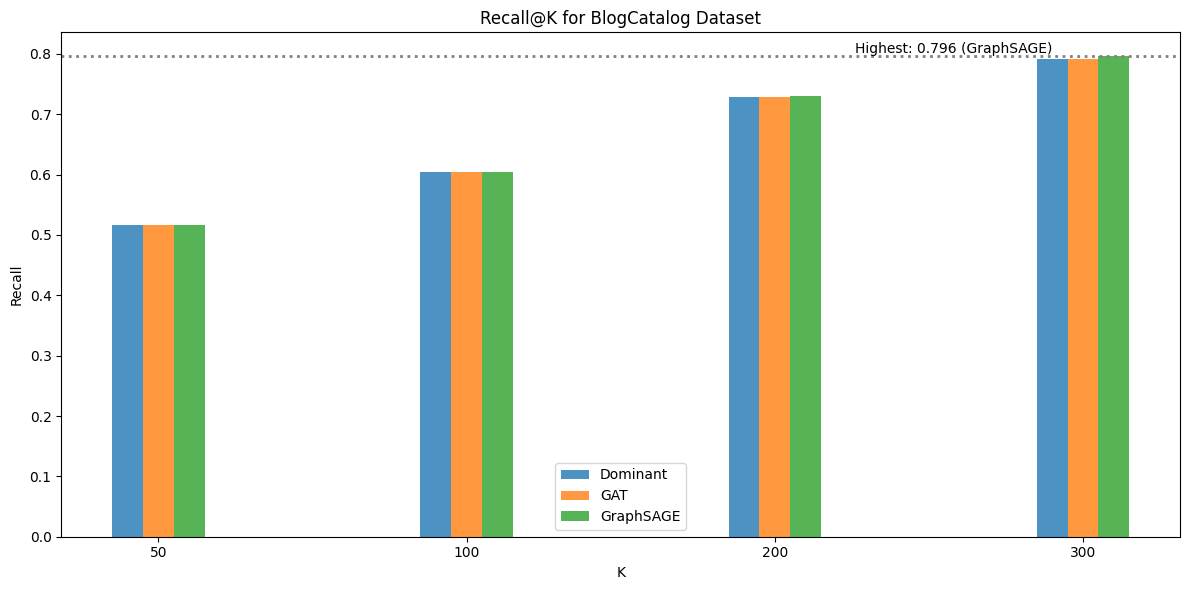

[0.522, 0.583, 0.671, 0.72, 0.536, 0.594, 0.682, 0.734, 0.52, 0.583, 0.671, 0.718]


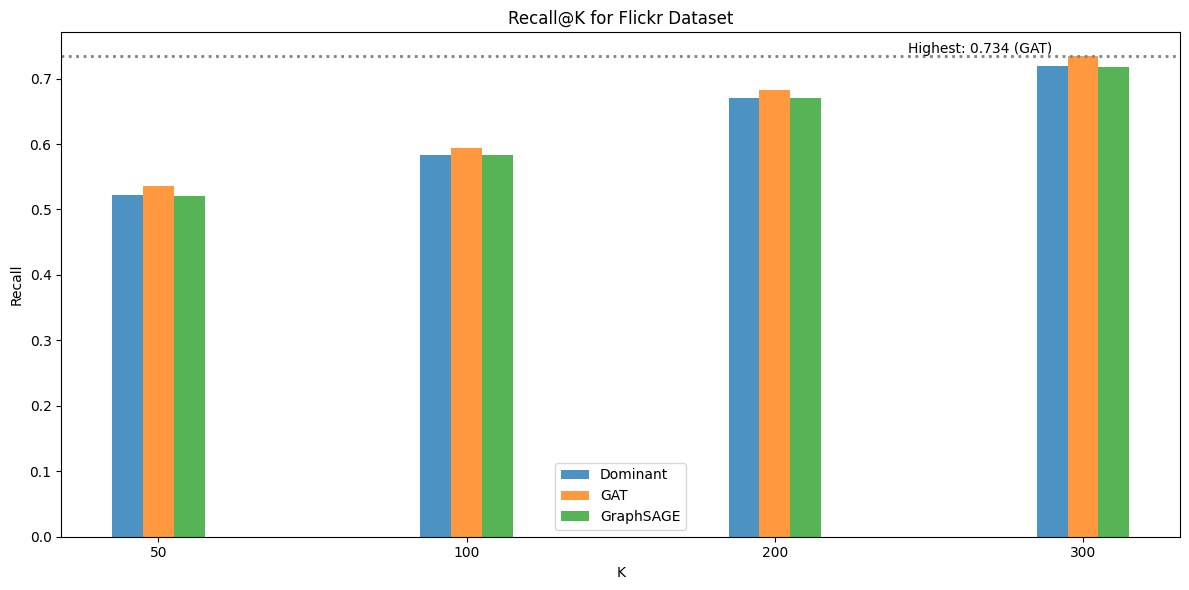

[0.41, 0.45, 0.47, 0.48, 0.42, 0.43, 0.45, 0.47, 0.42, 0.43, 0.45, 0.47, 0.506, 0.51, 0.514, 0.526]


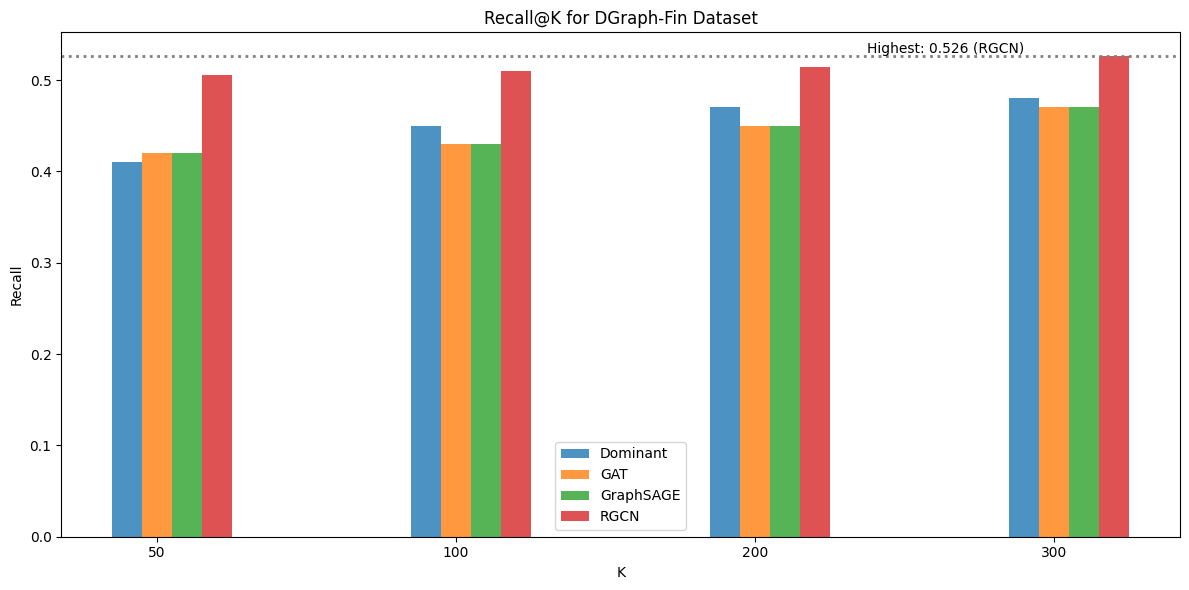

In [32]:
# plot Recall graphs
title = "Recall"
dominant_ACM = [0.613, 0.627, 0.657, 0.69]
gat_ACM = [0.613, 0.627, 0.657, 0.69]
graphSAGE_ACM = [0.613, 0.627, 0.657, 0.69]

plot_PR_graph(title, "ACM", dominant_ACM, gat_ACM, graphSAGE_ACM)

dominant_Blog = [0.517, 0.605, 0.729, 0.791]
gat_Blog = [0.517, 0.605, 0.729, 0.791]
graphSAGE_Blog = [0.517, 0.605, 0.73, 0.796]

plot_PR_graph(title, "BlogCatalog", dominant_Blog, gat_Blog, graphSAGE_Blog)

dominant_Flickr = [0.522, 0.583, 0.671, 0.720]
gat_Flickr = [0.536, 0.594, 0.682, 0.734]
graphSAGE_Flickr = [0.520, 0.583, 0.671, 0.718]


plot_PR_graph(title, "Flickr", dominant_Flickr, gat_Flickr, graphSAGE_Flickr)

dominant_Fin = [0.41, 0.45, 0.47, 0.48]
gat_Fin = [0.42, 0.43, 0.45, 0.47]
graphSAGE_Fin = [0.42, 0.43, 0.45, 0.47]
RGCN_Fin = [0.506, 0.51, 0.514, 0.526]

plot_PR_graph(title, "DGraph-Fin", dominant_Fin, gat_Fin, graphSAGE_Fin, RGCN_Fin)